# Хакатон Яндекс.Музыка

## Описание

### Что необходимо сделать?

Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков. Например:

- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

В этом хакатоне вам предлагается разработать решение, которое:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Совсем не обязательно, чтобы ваше решение умело делать все три функции. Будет уже здорово, если вы сможете придумать решение хотя бы для одной задачи.

Для решения этой задачи вы можете использовать любые открытые источники данных и собирать необходимую вам информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

### Метаинформация

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека

### Текст песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Полезные ссылки

- [https://musicbrainz.org](https://musicbrainz.org/)
- [https://acousticbrainz.org](https://acousticbrainz.org/)
- https://github.com/andreamust/MusicMetaLinker

# Подготовка. Импорт и необходимые функции

## Импорт

In [41]:
#!pip install -U sentence-transformers
#!pip install diameter-clustering

#!pip install musicbrainzngs
#!git clone https://github.com/alastair/python-musicbrainzngs.git

#Подключаем MusicMetaLinker
#!git clone https://github.com/andreamust/MusicMetaLinker.git
#!cd MusicMetaLinker
#!pip install -r MusicMetaLinker/requirements.txt

#!pip install -U sentence-transformers
#!pip install catboost
#!pip install shap
#!pip install phik
#!pip install faiss-cpu

In [42]:
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se
import re
import csv

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, \
                balanced_accuracy_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import phik
from phik.report import plot_correlation_matrix

from skimpy import skim
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

import random
import faiss
from faiss import write_index, read_index

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from catboost import CatBoostClassifier

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import random

# import musicbrainzngs
# import plotly.express as px
# import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

In [43]:
#Настройка графиков
se.set_style('darkgrid')
#%config InlineBackend.figure_formats = 'png' # svg Не работает :(
se.set(rc={'font.size': 8, 
           'figure.facecolor': 'white',
           'figure.figsize': (10, 6),
           'axes.edgecolor': 'black',
           'axes.facecolor': 'white',
           'axes.grid': True,
           'grid.color': 'black',
           'grid.linewidth': 0.5,
           'grid.alpha': 0.3,
           'grid.linestyle': '--',
           'text.color': 'black',
           'xtick.color': 'black',
           'ytick.color': 'black',
           'font.size': 10.0,
           'xtick.bottom': True,
           'xtick.top': False,
           'ytick.left': True,
           'ytick.right': True,
           'lines.linewidth': 1, 
           'patch.edgecolor': 'w',
           'lines.solid_capstyle': 'butt',
           'patch.linewidth': 0.2})

In [44]:
random_state = np.random.RandomState(42)
STATE = 102023
CUR_YEAR = datetime.now().year
#Colab
PTH1 = '/content/drive/MyDrive/ya.music/'
# Local
PTH2 = '/data/' 

In [45]:
def load_files(pth='/content/drive/MyDrive/ya.music/'):
    covers = pd.read_json(f"{pth}covers.json", lines = True)
    lyrics = pd.read_json(f"{pth}lyrics.json", lines = True)
    meta = pd.read_json(f"{pth}meta.json", lines = True)
    return covers, lyrics, meta

In [46]:
pd.DataFrame.iteritems = pd.DataFrame.items

## Слияние по track_id. Создание финального чистого датасета

В пердставленном датасете имеется всего 2 признака, позволяющие кластеризовать треки. Это текст песен и их название. В первую очередь необходимо слить имеющиеся данные по ключу track_id, это отсеит данные для которых отсутствуют тексты. 

In [47]:
#Создение дополнительных признаков из жанров
def creat_genre_data(data):
    track_genres = (data[['track_id',
                          'title',
                          'genres']].explode('genres')
                                    .fillna('unknown_genre')
                                    .pivot_table(index='track_id',
                                                columns='genres',
                                                values='title',
                                                aggfunc='count')
                                    .fillna(0))

    for col in track_genres.columns:
        track_genres[col] = track_genres[col].astype('int')
    return track_genres

In [48]:
# Создание признаков год в заголовке и 'cover' в заголовке
def year_cover_from_title(meta):
    meta['title_cover'] = meta['title'].apply(lambda x: 1 if (re.sub('[^a-zA-Z0-9\n\.]', ' ', x).lower().find(' cover') >=0) else 0)
    meta['title_year'] = meta['title'].apply(year_title).fillna('unknown')
    meta['len_title'] = meta['title'].apply(lambda x: len(x)).fillna(0)


In [49]:
#Загружаем данные и сливаем их в один
def upload_data(pth = '/content/drive/MyDrive/ya.music/') -> pd.DataFrame:
    #Загружем
    covers, lyrics, meta = load_files(pth)

    #Сперва соединим meta и covers по общим ключам
    data_meta_covers = pd.merge(meta, covers, on="track_id", how='inner')

    #Соединим предыдущий шаг с lyrics по ключам из lyrics
    data = pd.merge(data_meta_covers, lyrics, on="track_id", how='right')
    
    #Создаем признаки из жанров
    track_genres = creat_genre_data(data)
    #Сольём их снова
    data = pd.merge(data, track_genres, on="track_id", how='left')
    
    #Разбираем isrc на признаки
    add_isrc_features(data)
    
    #Уберем лишние признаки, заполним пропуски и преобразуем dttm
    #clean_data(data)
    #Удалим дубликаты по isrc
    #data.drop_duplicates(subset='isrc', inplace=True)

    #Удалим пропуски по разметке track_remake_type, так как они ненужны
    data = data.dropna(subset='track_remake_type')
    
    data.reset_index(drop=True, inplace=True)
    
    return data

In [50]:
def correct_isrc(isrc):
    if isrc == None:
        return False
    pattern = r'^[A-Z]{2}\w{3}\d{2}\d{5}$'
    match = re.fullmatch(pattern, isrc)
    if match:
        return True
    else:
        return False

def add_isrc_features(data: pd.DataFrame):
    data['isrc'].fillna('unknown', inplace=True)
    data['isrc_country_code'] = data['isrc'].dropna().apply(lambda x: str(x)[:2] if correct_isrc(x) else 'unknown')
    data['isrc_issuer'] = data['isrc'].dropna().apply(lambda x: str(x)[2:5] if correct_isrc(x) else 'unknown')
    data['isrc_issuer_full'] = data['isrc'].dropna().apply(lambda x: str(x)[:5] if correct_isrc(x) else 'unknown')
    data['isrc_year'] = data['isrc'].dropna() \
                                    .apply(lambda x: 'unknown' if not correct_isrc(x)
                                                               else('19'+x[5:7] if (int(x[5:7]) >= 40)
                                                               else '20'+x[5:7] ))
                                    
    data.loc[data['isrc_year'] == 'unknown', 'isrc_year'] = 0
    #Пока поставим год как категорию
    data['isrc_country_code'] =  data['isrc_year'].astype('category')
    data['isrc_issuer'] =  data['isrc_year'].astype('category')
    data['isrc_issuer_full'] =  data['isrc_year'].astype('category')
    #data['isrc_year'] =  data['isrc_year'].astype('category')
    data['isrc_year'] = data['isrc_year'].astype('int')

In [51]:
def clean_data(data: pd.DataFrame):
    #Удаляем признаки original_track_id и lyricId
    data.drop(columns=['original_track_id', 'lyricId'], inplace=True)
    #Все пропуски заполняем unknown
    data['language'].fillna('unknown', inplace=True)
    #Преобразуем dttm
    data['dttm'] = pd.to_datetime(data['dttm']/ 1000,unit='s')

Здесь выжным вопросом будет, правильно ли это оценивается. Все ответы для кластеризации достоверно есть в
базе данных. Из-за этого метрика будет очень высокой. С другой стороны можно убрать проверку наличия ответа в базе,
это ухудшит метрику но больше приблизит к реальной ситуации.

Было решено, что на этом этапе первостепенной задачей является построение модели для кластеризации, поэтому проверку
наличия ответа для тренировочного датасета я оставил.

Проверка будет работать следующим образом. У нас есть достоверно известная связки COVER <--> ORIGINAL.
После нахождения похожих треков, мы будем проверять попала ли его связка в полученную группу. Метрика будет accuracy@n.

In [52]:
#Формируем тестовый датасет
def create_test_data(data: pd.DataFrame) -> pd.DataFrame:
    #Копируем, чтобы не изменять оригинал
    new_data = data.copy()
    
    #Почистим исходный датасет
    clean_data(data)
    
    #Отделяем каверы с известными оригиналами для которых ответы есть в датасете
    data_with_answer = new_data[(~new_data['original_track_id'].isna()) & 
                                    (new_data['track_remake_type'] == 'COVER') &
                             (new_data['original_track_id'].isin(new_data['track_id'].tolist()))]
     
    #Сохраним track_id каверов для которых достоверно есть оригинал
    track_id_cover = data_with_answer['track_id'].tolist()
    
    #Сохраним original_track_id оригиналов для которых достоверно есть кавер
    track_id_original = data_with_answer['original_track_id'].tolist()
    
    answer ={**{k: a for k, a in zip(track_id_cover, track_id_original)},
             **{k: a for k, a in zip(track_id_original, track_id_cover)}}
    #Сформируем тестовый датасет
    test_dataset = new_data[(new_data['track_id'].isin(track_id_cover)) | 
                           (new_data['track_id'].isin(track_id_original))]
    
     
    
    #Почистим тренировочный датасет
    clean_data(test_dataset)
    
    return test_dataset, answer 

# EDA и анализ

In [53]:
covers, lyrics, meta = load_files(pth='data/')

In [54]:
print("Размер covers =", covers.shape)
print("Размер lyrics =", lyrics.shape)
print("Размер meta =", meta.shape)

Размер covers = (71597, 3)
Размер lyrics = (11414, 3)
Размер meta = (71769, 7)


In [55]:
#Количесвто уникальных треков в файле covers
print("Количесвто уникальных треков в файле covers = ", len(covers['track_id'].unique()))
#Количесвто уникальных треков в файле lyrics
print("#Количесвто уникальных треков в файле lyrics = ", len(lyrics['track_id'].unique()))
#Количесвто уникальных треков в файле meta
print("#Количесвто уникальных треков в файле meta = ", len(meta['track_id'].unique()))

Количесвто уникальных треков в файле covers =  71597
#Количесвто уникальных треков в файле lyrics =  10277
#Количесвто уникальных треков в файле meta =  71769


## Covers

In [56]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


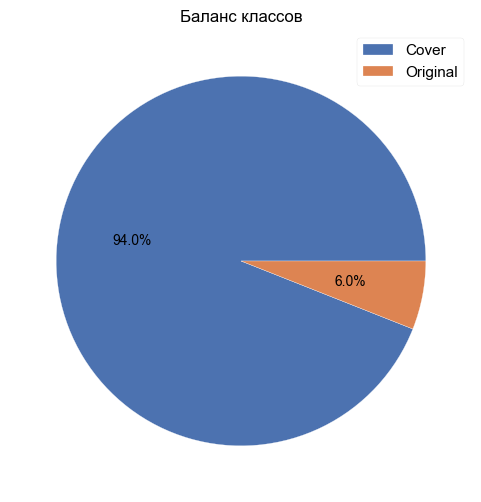

In [57]:
(covers.groupby('track_remake_type')
       .count()['track_id']
       .plot(kind='pie',
             autopct='%1.1f%%',
             figsize=(6,6),
             labels = None)
)
plt.legend(['Cover', 'Original'])
plt.title('Баланс классов')
plt.ylabel('')
plt.show()

In [58]:
#Количесвто пропусков в original_track_id
covers.isna().sum()

original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64

In [59]:
#Соотнешения каверов и оригиналов для достоверно известных ответов
covers[~covers['original_track_id'].isna()]['track_remake_type'].value_counts()

track_remake_type
ORIGINAL    4293
COVER        528
Name: count, dtype: int64

## lyrics

In [60]:
lyrics.info()
lyrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


In [61]:
# пропуски
lyrics.isna().sum()

lyricId     0
text        0
track_id    0
dtype: int64

In [62]:
lyrics.nunique()

lyricId     10915
text        10644
track_id    10277
dtype: int64

Во всех столбцах есть повторы.<br> Рассмотрим полностью повторяющиеся строки

In [63]:
lyrics.duplicated().sum()

0

Одному треку может соответствовать лишь один текст, но при этому текст может соответствовать нескольким трекам.<br>
Посмотрим сколько у нас дубликатов с разными lyricId. Удалим дубликаты.

In [64]:
display(lyrics[['text', 'track_id']].duplicated().sum())

264

Рассмотрим сколько разных текстов относятся к одному track_id.<br>
Создадим столбец "длина текста".

In [65]:
lyrics = lyrics[~lyrics[['text', 'track_id']].duplicated()]

Рассмотрим сколько разных текстов относятся к одному track_id.<br>
Создадим столбец "длина текста".

In [66]:
display(lyrics[['track_id']].duplicated().sum())
lyrics['len_text'] = lyrics['text'].apply(lambda x: len(x)).fillna(0)
lyrics['count_rows_text'] = lyrics['text'].apply(lambda x: len(x.split('\n'))).fillna(0)
lyrics[lyrics[['track_id']].duplicated(keep=False)].sort_values(by='track_id')

873

,lyricId,text,track_id,len_text,count_rows_text
10676,745f700051961898c65ffdafd9793584,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef,1765,100
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef,1748,83
4796,9ee5ee7522b5b6d045a2d276a040d00c,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a,532,21
9220,6e3781576e60cfbee15f65d626ac130a,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a,779,31
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a,852,32
...,...,...,...,...,...
4814,0e36ae7acbfee10d69cb8668b77f6403,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97,1926,57
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97,1905,66
8895,c8af153ec09b0a087e79a0f77f7310bd,Don't go tonight\nStay here one more time\nRem...,ff77df3ccccd54654ea4b2209dd6e38c,791,24
8881,d9107cc98fb6dc91853ea69ac98f1d58,Don't go tonight\nStay here one more time\nRem...,ff77df3ccccd54654ea4b2209dd6e38c,801,28


Рассмотрим как сильно отличается текст по количеству символов

In [67]:
lyrics['len_text'].describe(percentiles=[.10, .90, .98])

count    11150.000000
mean      1248.381794
std        556.146789
min         13.000000
10%        650.000000
50%       1165.000000
90%       1925.100000
98%       2702.060000
max       8163.000000
Name: len_text, dtype: float64

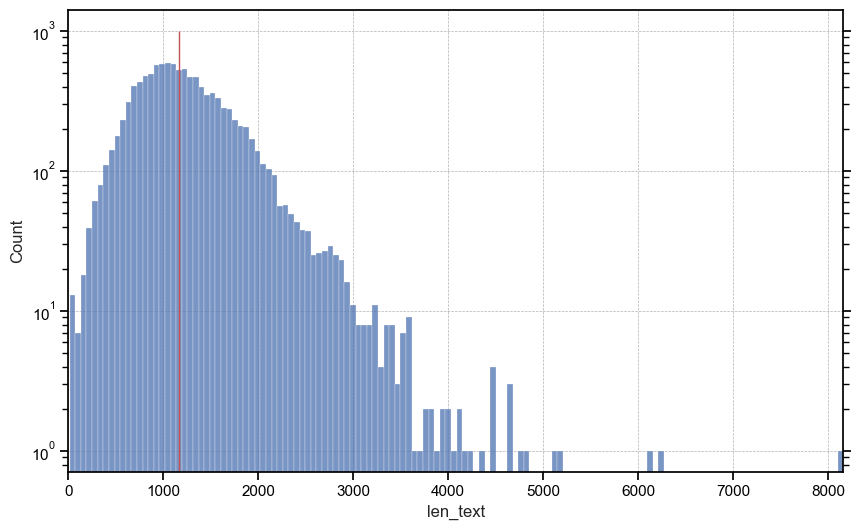

In [68]:
# Строим гистограмму с медианой
se.histplot(lyrics['len_text'])
plt.yscale('log')
plt.xlim([0, max(lyrics['len_text'])])
plt.vlines(x=lyrics['len_text'].median(), ymin=0, ymax=1000, colors='r')

In [69]:
#Выведем аномально короткий и аномально длинный текст
display(lyrics[lyrics['len_text'] == 13]['text'].values)
print()
lyrics[lyrics['len_text'] == 8163]['text'].values[0][:3000]

array(['The Simpsons!'], dtype=object)

'Instagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\nInstagram: rebelofficialx\n

In [70]:
(lyrics[lyrics[['track_id']].duplicated(keep=False)][['track_id', 'len_text']]
                            .groupby('track_id')
                            .agg(['min', 'max', 'std', 'count'])
                            .sort_values(by=('len_text', 'std'), ascending=False)
)

len_text                         
                                      min   max          std count
track_id                                                          
a4af115abce62bd2e50d3fc4e9cf91ea     1161  3390  1576.141015     2
07e9a06bbbef7e0b6f84ba92665ecb44     2222  4116  1339.260244     2
a2b4648b3e4c261605bc3be519607308     1026  2885  1314.511506     2
d5c149b59a800a6f9f61adda6d3e1b1d      764  2429  1177.332791     2
10463f622a537e2d3c3309d7f41e7dae     1000  3049  1005.700751     4
...                                   ...   ...          ...   ...
d6f6d383ad031e1c84ce7bdbc082e4d3      942   942     0.000000     2
8ed9637462282754c368965288ba3426      941   941     0.000000     2
63e0b4fbf67cfe5ebfa5f94186a9dda0      502   502     0.000000     2
ee576d0879fc1a2c68ebc758c799a64b     1811  1811     0.000000     2
d93b89d3a76432ce4dd864af47647966      984   984     0.000000     2

[584 rows x 4 columns]

Рассмотрим идентификатор a4af115abce62bd2e50d3fc4e9cf91ea, у которого текст песни сильно отличается по длине.

In [71]:
lyrics[lyrics['track_id'] == 'a4af115abce62bd2e50d3fc4e9cf91ea'][['text', 'len_text']]

,text,len_text
3198,I feel so unsure\nAs I take your hand and lead...,3390
5453,I feel so unsure\nAs I take your hand and lead...,1161


In [72]:
print(lyrics.loc[3198]['text'])

I feel so unsure
As I take your hand and lead you to the dancefloor
As the music dies, something in your eyes
Calls to mind the silver screen
And all it's sad goodbyes

I'm never gonna dance again (no no)
Guilty feet have got no rhythm
Though it's easy to pretend
I know your not a fool (you and you alone)
Shoulda known better than to cheat a friend(shoulda known)
Waste this chance that I've been given
No I'm never gonna dance again
The way I danced with you

Do you love me as I move girl
Baby give my life up to you girl
The one that couldn't bump us for you girl
The girl can't compare to me when you live my lifes and nightmares
Just one last time

So baby baby one more chance
Your love and the sweetest romance
Just one last time, without you girl I'm blind and a record label that's mine
Sing again

Time can never mend, no
The careless whispers of a good friend
To the heart and mind
Ignorance is kind
There's no comfort in the truth
Pain is all you'll find

I'm never gonna dance again
Gu

In [73]:
print(lyrics.loc[5453]['text'])

I feel so unsure
As I take your hand and lead you to the dancefloor
As the music dies, something in your eyes
Calls to mind the silver screen
And all those sad goodbyes
I'm never gonna dance again
Guilty feet have got no rhythm
Though it's easy to pretend
I know your not a fool
Shoulda known better than to cheat a friend
And waste this chance that I've been given
So I'm never gonna dance again
The way I danced with you

Time can never mend
The careless whispers of a good friend
To the heart and mind
Ignorance is kind
There's no comfort in the truth
Pain is all you'll find

I'm never gonna dance again
Guilty feet have got no rhythm (rhythm no)
Though it's easy to pretend
I know your not a fool (no, no,)
Shoulda known better than to cheat a friend
Than waste this chance that I've been given
So I'm never gonna dance again
The way I danced with you

We could have been so good together
We could have made this last forever
But now who's gonna dance with me?
Please stay
Stay, stay, stay
I can

Вероятнее всего текст сокращенный и полный.

In [74]:
# Сортировка по длине по убыванию и отсекание более коротких
lyrics.sort_values(by='len_text', ascending=False, inplace=True)
lyrics = lyrics[~lyrics['track_id'].duplicated()]

## Meta

In [75]:
meta.info()
meta.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [76]:
# кол-во уникальных значений
meta[['track_id', 'dttm', 'title', 'isrc', 'duration']].nunique()

track_id    71768
dttm        27726
title       45462
isrc        71283
duration    23597
dtype: int64

In [77]:
meta.isna().sum()

track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          1
duration        1
dtype: int64

In [78]:
# Удалим полностью пустую строку
meta.dropna(subset=['track_id'], inplace=True)

### Языки

In [79]:
meta['language'].value_counts().head(20)

language
EN    15322
ES     1747
RU     1558
IT      907
HI      285
DE      238
ZH      212
FR      210
JA      174
VI      162
TH      162
PT      114
ID      111
PA       50
SI       49
TA       49
ML       47
TR       43
AR       41
PL       35
Name: count, dtype: int64

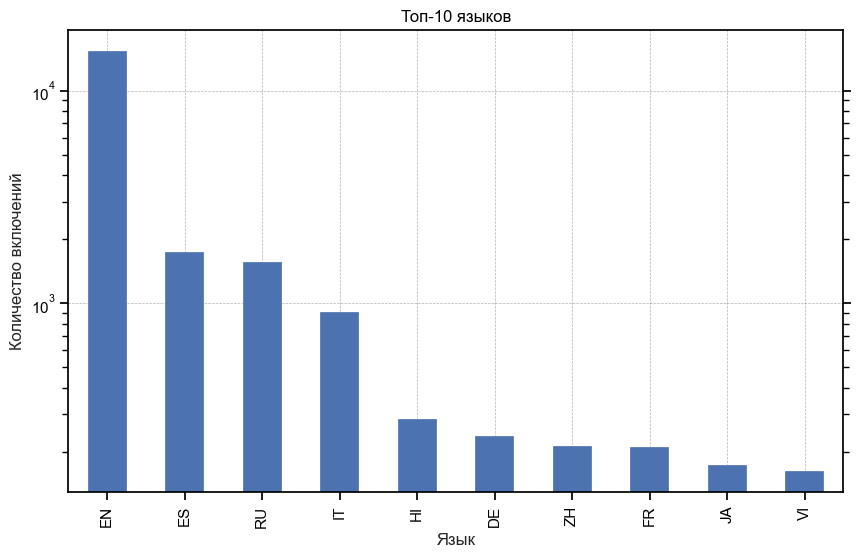

In [80]:
top_10 = meta['language'].value_counts(ascending=False).head(10)

top_10.plot(kind='bar')
plt.yscale('log')
plt.title('Топ-10 языков')
plt.xlabel('Язык')
plt.ylabel('Количество включений')
plt.show()

Заполним возможные пропуски внутригрупповым значением, для треков с одинаковым isrc.

In [81]:
#meta['language'].fillna('unknown', inplace=True)

In [82]:
#заполнение самыми высокочастотными внутрегрупповыми (по ISRC) значениями
# meta['language'] = meta.groupby("isrc")['language'] \
#                        .transform(lambda x: x.fillna(x.value_counts().index[0]) if x.value_counts().shape[0] != 0 else x)

Заполним пропуски значением 'unknown'.

In [83]:
meta['isrc'].fillna('unknown', inplace=True)

### Рассмотрим столбец title


In [84]:
meta['title'].value_counts().head(20)

title
Morena                     81
Smooth Criminal            75
Rolê                       72
Wicked Game                67
Esquema Preferido          66
Meia Noite                 57
Facas                      57
Perfect                    53
Smells Like Teen Spirit    53
Ficha Limpa                51
Baby Me Atende             51
Wonderwall                 50
Toxic                      49
Stay                       47
Romance Desapegado         47
Acaso                      46
Blinding Lights            45
A Maior Saudade            43
Creep                      42
Baby One More Time         41
Name: count, dtype: int64

Добавим новый признак, который будет фиксировать наличие слова cover в названии.

In [85]:
meta['title_cover'] = meta['title'].apply(lambda x: 1 if (re.sub('[^a-zA-Z0-9\n\.]', ' ', x).lower().find(' cover') >=0) else 0)
meta['title_cover'].sum()

121

Добавим новый признак, который будет извлекать год из названия.

In [86]:
def year_title(title):
    year = None
    for i in range(1934, 2023, 1):
        if title.find(str(i)) >=0:
            if year == None:
                year = i
            else:
                return None
    return year

meta['title_year'] = meta['title'].apply(year_title).astype('Int16').fillna(0)

In [87]:
year_cover_from_title(meta)

### Посмотрим на жанры

In [88]:
meta['genres'].explode().unique()

array(['DANCE', 'ELECTRONICS', 'FOLK', 'LATINFOLK', 'JAZZ', 'CONJAZZ',
       'POP', 'SOUL', 'RNB', 'PUNK', 'ROCK', 'ALLROCK', 'ALTERNATIVE',
       'SOUNDTRACK', 'SPIRITUAL', 'CLASSICMETAL', 'METAL', 'RNR',
       'ANIMEMUSIC', 'ESTRADA', 'HOUSE', 'RUSPOP', 'FOREIGNBARD', 'BARD',
       'CLASSICAL', 'CLASSICALMUSIC', 'FOREIGNRAP', 'RAP', 'COUNTRY',
       'RUSRAP', 'AMBIENTGENRE', 'REGGAE', 'REGGAETON', 'CHILDREN', nan,
       'BLUES', 'VOCAL', 'RUSROCK', 'AFRICAN', 'INDIE', 'FOLKROCK',
       'ASIAPOP', 'NEWAGE', 'CAUCASIAN', 'EASTERN', 'FORCHILDREN',
       'RELAX', 'SKA', 'BLACKMETAL', 'DNB', 'DISCO', 'PROGMETAL',
       'AMERFOLK', 'LOCAL-INDIE', 'PHONKGENRE', 'VIDEOGAME', 'FAIRYTALES',
       'RUSESTRADA', 'DEATHMETAL', 'NEWWAVE', 'HARDROCK',
       'ALTERNATIVEMETAL', 'FUNK', 'HARDCORE', 'JAPANESEPOP', 'BOLLYWOOD',
       'POSTHARDCORE', 'EXPERIMENTAL', 'KPOP', 'MODERN', 'EXTREMEMETAL',
       'FOLKGENRE', 'HYPERPOPGENRE', 'EDMGENRE', 'GOTHICMETAL',
       'FOLKMETAL', 'TRANCE',

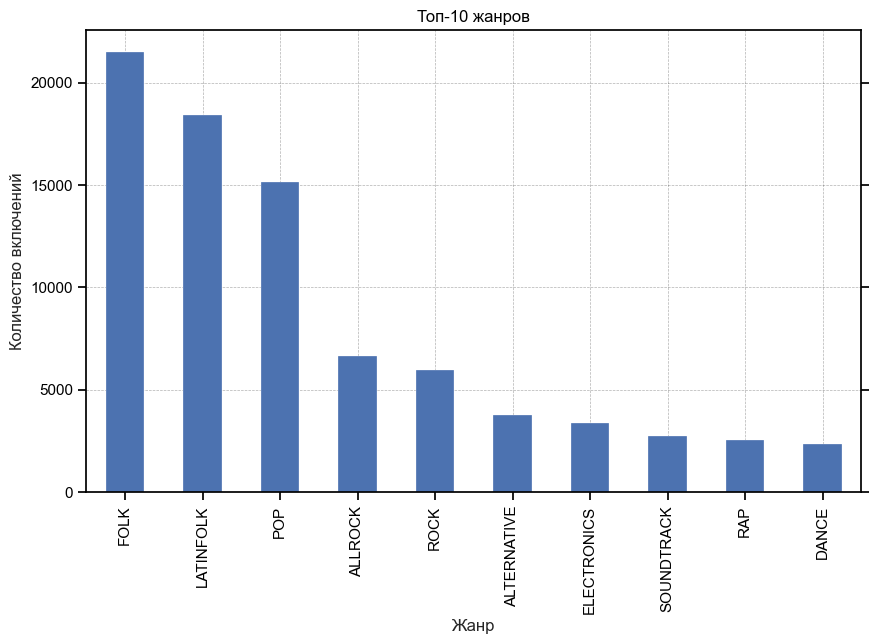

In [89]:
top_10 = meta['genres'].explode().value_counts(ascending=False).head(10)

top_10.plot(kind='bar')
plt.title('Топ-10 жанров')
plt.xlabel('Жанр')
plt.ylabel('Количество включений')
plt.show()

Присутствуют пропуски.<br>
Так как каждому треку может относиться несколько жанров, создадим для каждого track_id таблицу признаков, которыми будут являться жанры<br>


#### Создание признаков-жанров

In [90]:
track_genres = creat_genre_data(meta)
track_genres.head()

genres,AFRICAN,ALLROCK,ALTERNATIVE,ALTERNATIVEMETAL,AMBIENTGENRE,AMERFOLK,ANIMATED,ANIMEMUSIC,ARABESQUEMUSIC,ARABICPOP,...,TURKISHPOP,TURKISHRAP,TURKISHROCK,TVSERIES,UKRROCK,UZBEKPOP,VIDEOGAME,VOCAL,VOCALJAZZ,unknown_genre
track_id,,,,,,,,,,,,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00017038a565df4b72048268e7623599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0002e85381698128b8b2a0f578ac2054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003734c0dce387667e659709b20934e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000545f7357ee9a4bd1438505406875c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
meta['count_genres'] = meta['genres'].apply(lambda x: len(x)).fillna(0)

### Посмотрим на столбец времени dttm

In [92]:
print('Наиболее старые треки:',meta['dttm'].min())
print('Наиболее новые треки:',meta['dttm'].max())

Наиболее старые треки: 1249925526000.0
Наиболее новые треки: 1697662800000.0


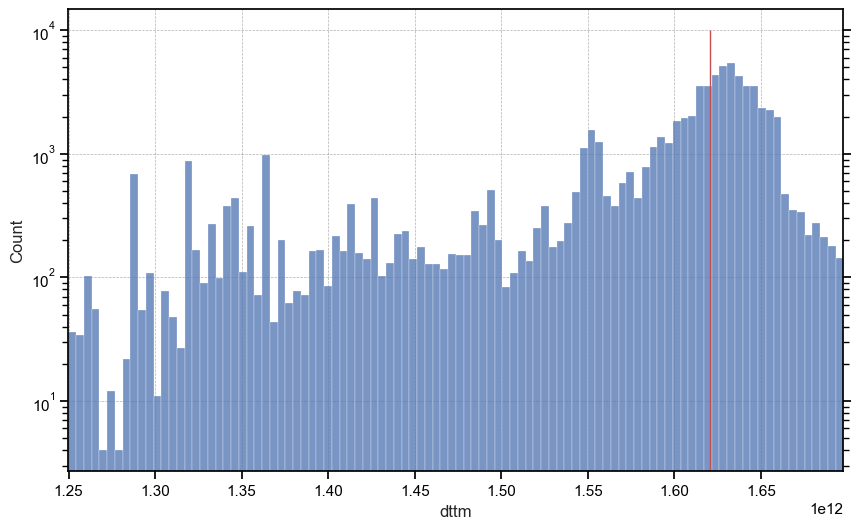

In [93]:
# Строим гистограмму с медианой
se.histplot(meta['dttm'], bins=100)
plt.yscale('log')
plt.xlim([min(meta['dttm']), max(meta['dttm'])])
plt.vlines(x=meta['dttm'].median(), ymin=0, ymax=10000, colors='r')

Бум упоминаний треков приходится на октябрь-ноябрь 2021

Посмотрим по количеству копий трека

(1.0, 81.0)

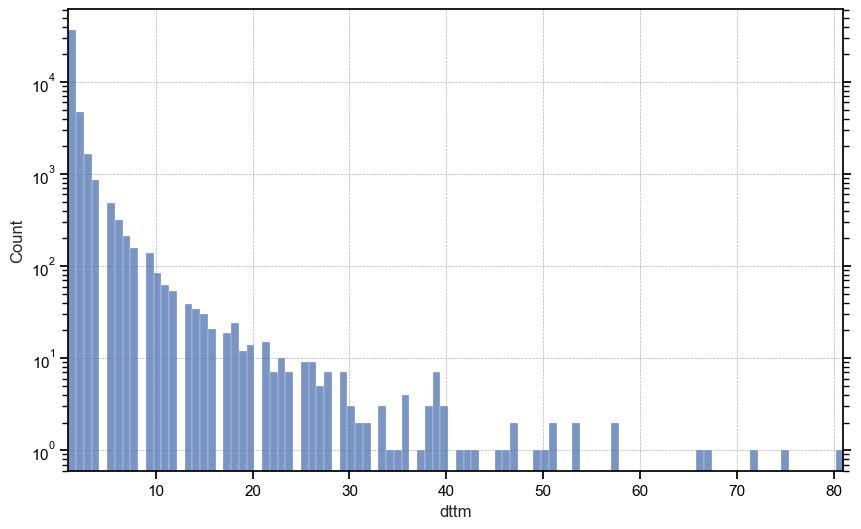

In [94]:
# Строим гистограмму
unique_title = meta.groupby('title')['dttm'].count().sort_values(ascending=False)
se.histplot(unique_title, bins=100)
plt.yscale('log')
plt.xlim([min(unique_title), max(unique_title)])

Большая часть данных судя по всему не имеет каверов, треки с первым и единственным упоминанием доминируют в данных, если не брать во внимание случаи одинаковых названий


(1.0, 81.0)

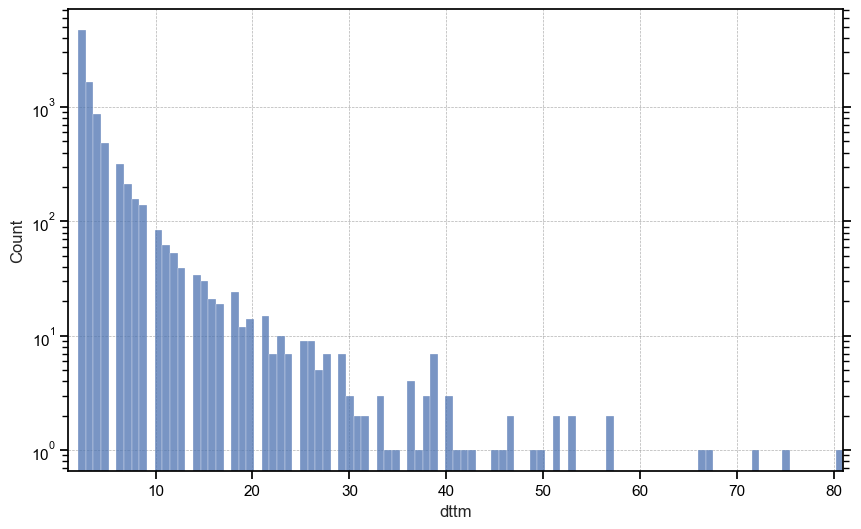

In [95]:
# Строим гистограмму
se.histplot(unique_title[unique_title>1], bins=100)
plt.yscale('log')
plt.xlim([min(unique_title), max(unique_title)])

#### Извлечем год из столбца и создадим новый признак

In [96]:
meta['dttm_year'] = pd.to_datetime(meta['dttm']/1000,unit='s').dt.year

### Обработка столбца 'isrc'

Структура кода ISRC XXCCCYYNNNNN:<br>
- XX - код страны<br>
- ССС - код эмитента. Используется совместно с кодом страны.<br>
- YY - год присвоения кода<br>
- NNNNN - индентификатор муз. композиции. Используется совместно с годом.


In [97]:
def correct_isrc(isrc):
    if isrc == None:
        return False
    pattern = r'^[A-Z]{2}\w{3}\d{2}\d{5}$'
    match = re.fullmatch(pattern, isrc)
    if match:
        return True
    else:
        return False

print('Пустых ISRC:', meta['isrc'].isna().sum())
print('Дубликатов ISRC:', meta['isrc'].dropna().duplicated().sum())
print('Некорректных ISRC:', - meta['isrc'].dropna().apply(correct_isrc).sum() + len(meta['isrc'].dropna()))

Пустых ISRC: 0
Дубликатов ISRC: 484
Некорректных ISRC: 314


Выведем некорректный ISRC. По возможности преобразуем.

In [98]:
meta[~meta['isrc'].apply(correct_isrc)]['isrc'].dropna()

2151     unknown
2185     unknown
2238     unknown
2317     unknown
3838     unknown
          ...   
71703    unknown
71704    unknown
71705    unknown
71706    unknown
71707    unknown
Name: isrc, Length: 314, dtype: object

In [99]:
meta['isrc'] = meta['isrc'].apply(lambda x: x.replace('-', '') if x else x)

Извлечем признаки

In [100]:
meta['isrc_country_code'] = meta['isrc'].dropna().apply(lambda x: str(x)[:2] if correct_isrc(x) else 'unknown')
meta['isrc_issuer'] = meta['isrc'].dropna().apply(lambda x: str(x)[2:5] if correct_isrc(x) else 'unknown')
meta['isrc_issuer_full'] = meta['isrc'].dropna().apply(lambda x: str(x)[:5] if correct_isrc(x) else 'unknown')
meta['isrc_year'] = meta['isrc'].dropna() \
                                .apply(lambda x: 0 if not correct_isrc(x)
                                                           else('19'+x[5:7] if (int(x[5:7]) >= 35)
                                                           else '20'+x[5:7] ))                                                                         
meta.sample(5)

,track_id,dttm,title,language,isrc,genres,duration,title_cover,title_year,len_title,count_genres,dttm_year,isrc_country_code,isrc_issuer,isrc_issuer_full,isrc_year
65286,11e6f65e21b1d8152964b21c5794cb0f,1.617453e+12,Rise Up,None,QZGLS2151713,[POP],277150.0,0,unknown,7,1,2021,QZ,GLS,QZGLS,2021
35929,36755650e615cf4eefd9e0ab687542c0,1.633348e+12,Se For Amor,None,QZNJX2102273,"[FOLK, LATINFOLK]",239830.0,0,unknown,11,2,2021,QZ,NJX,QZNJX,2021
52981,dcd746f39d4e16437de9d42cb1c3a2de,1.695416e+12,Scars,EN,TCADH1763096,[ALTERNATIVE],98010.0,0,unknown,5,1,2023,TC,ADH,TCADH,2017
22645,805b67dfd69b747a4f1dd310cd43461f,1.620867e+12,Uma Brasileira,None,QZHZ42116879,[POP],195740.0,0,unknown,14,1,2021,QZ,HZ4,QZHZ4,2021
21761,f844a2a0a42255570ad4eaffae708439,1.621458e+12,Streets of Philadelphia,EN,DEAK82100001,"[ROCK, ALLROCK]",163130.0,0,unknown,23,2,2021,DE,AK8,DEAK8,2021


Рассмотрим дубликаты.

In [101]:
meta.dropna(subset=['isrc']).sort_values(by='isrc').loc[meta['isrc'].duplicated(keep=False)]

,track_id,dttm,title,language,isrc,genres,duration,title_cover,title_year,len_title,count_genres,dttm_year,isrc_country_code,isrc_issuer,isrc_issuer_full,isrc_year
26955,8aff9d28865aaf1fa44e46b82cba0f63,1.625586e+12,Burma,None,ATAJ12100470,[FOLK],179300.0,0,unknown,5,1,2021,AT,AJ1,ATAJ1,2021
27012,be0233f57dbb59079929ac646b0b9d5c,1.625590e+12,Zivot da stane ne sme,None,ATAJ12100470,[FOLK],151190.0,0,unknown,21,1,2021,AT,AJ1,ATAJ1,2021
51052,196a0973d73122891a426f8334105ce7,1.553893e+12,Inní mér syngur vitleysingur,EN,ATN261668711,"[FOLKMETAL, METAL]",237010.0,0,unknown,28,2,2019,AT,N26,ATN26,2016
66395,425761c88ebc69e89c748eb537671953,1.524943e+12,Inni Mer Syngur Vitleysingur,None,ATN261668711,"[FOLKMETAL, METAL]",237010.0,0,unknown,28,2,2018,AT,N26,ATN26,2016
66396,466df43223bcc7e5d0973e9038890fb7,1.524943e+12,Nattfodd,None,ATN261668712,"[FOLKMETAL, METAL]",255380.0,0,unknown,8,2,2018,AT,N26,ATN26,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,fb97e639240fb249756b40e0f88387cb,1.640334e+12,Глава 12. Пятно,None,unknown,[FAIRYTALES],103280.0,0,unknown,15,1,2021,unknown,unknown,unknown,0
16767,395190e98e079bfefb670f28d89a4f51,1.572278e+12,Oydin kechalar,None,unknown,"[POP, UZBEKPOP]",176950.0,0,unknown,14,2,2019,unknown,unknown,unknown,0
43049,f42df63cb6627c6efa3cef11ebb4e670,1.421413e+12,Новый год,None,unknown,[INDIE],303840.0,0,unknown,9,1,2015,unknown,unknown,unknown,0
16778,d7b187759005fb8134c927881fa44a83,1.572359e+12,Wicked Game,None,unknown,"[ELECTRONICS, TRANCE]",278510.0,0,unknown,11,2,2019,unknown,unknown,unknown,0


В данном случае нескольким track_id принадлежит один isrc. Это могло получиться в том случае, когда трек выпускался в нескольких альбомах.<br>
Воспользуемся данной ситуацией для заполнения пропусков.

In [102]:
meta.dropna(subset=['isrc']).sort_values(by='isrc').loc[meta['isrc'].duplicated(keep=False)].isna().sum()

track_id               0
dttm                   0
title                  0
language             507
isrc                   0
genres                 0
duration               0
title_cover            0
title_year             0
len_title              0
count_genres           0
dttm_year              0
isrc_country_code      0
isrc_issuer            0
isrc_issuer_full       0
isrc_year              0
dtype: int64

In [103]:
# заполнение самыми высокочастотными внутрегрупповыми (ISRC) значениями
# meta['language'] = meta.groupby("isrc")['language'] \
#                        .transform(lambda x: x.fillna(x.value_counts().index[0]) if x.value_counts().shape[0] != 0 else x)

In [104]:
meta.dropna(subset=['isrc']).loc[meta['isrc'].duplicated(keep=False)]['language'].isna().sum()

507

In [105]:
meta.columns

Index(['track_id', 'dttm', 'title', 'language', 'isrc', 'genres', 'duration',
       'title_cover', 'title_year', 'len_title', 'count_genres', 'dttm_year',
       'isrc_country_code', 'isrc_issuer', 'isrc_issuer_full', 'isrc_year'],
      dtype='object')

In [106]:
#Заполним пропуски значением 'unknown'.
meta['isrc'].fillna('unknown', inplace=True)

In [107]:
meta['dttm'].shape

(71768,)

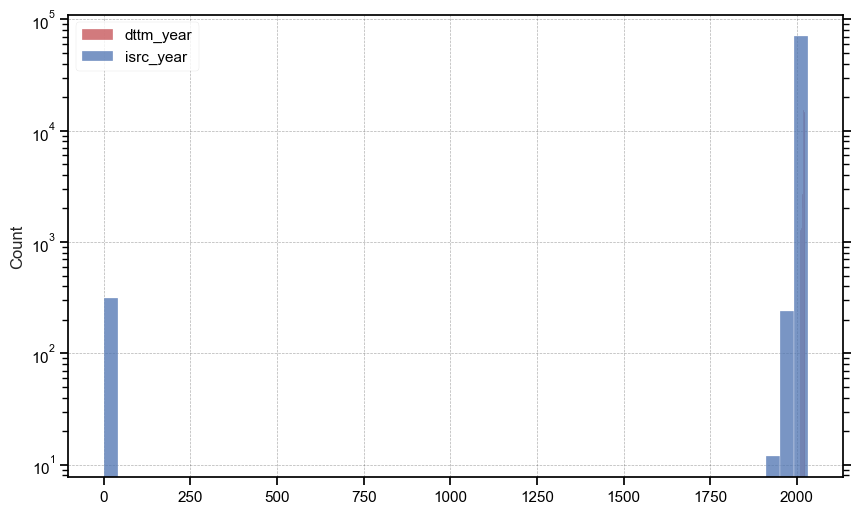

In [108]:
fig, ax = plt.subplots()
se.histplot(x=meta[meta['dttm_year'] != 0]['dttm_year'].astype('int').values, ax=ax, bins=10, color='r', legend=True)
se.histplot(x=meta[meta['isrc_year'] != 0]['isrc_year'].astype('int').values, ax=ax, bins=50, legend=True)
plt.yscale('log')
plt.legend(["dttm_year", "isrc_year"])

In [109]:
print('Наиболее старые треки:',meta[meta['isrc_year'] != 0]['isrc_year'].min())
print('Наиболее новые треки:', meta[meta['isrc_year'] != 0]['isrc_year'].max())

Наиболее старые треки: 1935
Наиболее новые треки: 2033


Аномалии с годом больше 23 нельзя найти в базе isrc

## Вывод по EDA

**Covers:**
- соотношение треков оригинал/кавер -  6%/94%
- пропуски только в `original_track_id`, их там большая часть 66776 на 71597 строк

**lyrics:**
- во всех столбцах есть повторы.
- пропусков нет
- медианная длина текста находится в  1165 символах, существую аномалии с слишком коротким или большими текстами
  
**meta:**
- пропуски пресутсвуют в языках и isrc, причем в языке большая часть
- Топ 10 жанров :`'FOLK', 'LATINFOLK', 'POP', 'ALLROCK', 'ROCK', 'ALTERNATIVE','ELECTRONICS', 'SOUNDTRACK', 'RAP', 'DANCE'`
- Наиболее популярные языки: Английский, Испанский, Русский
- Время самое ранние упоминания из столбца `ddtm` 08.2009 последнее 2023-10,бум упоминаний треков приходится на октябрь-ноябрь 2021
- Большая часть данных судя по всему не имеет каверов, треки с первым и единственным упоминанием доминируют в данных, если не брать во внимание случаи одинаковых названий
- Для столбца `isrc` извлекли признаки, проверили на корректность, существуют трек для которых  один isrc для разных track_id, возможно из-за того что один трек в разные альбомы
- Дата из `isrc` не всегда совпадает с датой в `ddtm`, есть аномалии с данными больше чем 23 год и их нельзя найти в базе

# Слияние по track_id. Создание финального датасета

In [110]:
covers.shape, lyrics.shape, meta.shape, track_genres.shape

((71597, 3), (10277, 5), (71768, 16), (71768, 129))

In [111]:
covers.info(), lyrics.info(), meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10277 entries, 771 to 10785
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   lyricId          10277 non-null  object
 1   text             10277 non-null  object
 2   track_id         10277 non-null  object
 3   len_text         10277 non-null  int64 
 4   count_rows_text  10277 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 481.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 71768 entries, 0 to 71768
Data columns (total 16 columns):
 #   Column             Non-Null Count  D

(None, None, None)

In [223]:
df = covers.set_index('track_id').join(meta.set_index('track_id').drop('genres', axis=1), how='outer') \
                                 .join(lyrics.set_index('track_id').drop('lyricId', axis=1), how='outer') \
                                 .join(track_genres)

df['dttm_year'] = df['dttm_year'].fillna(0).astype('int')
df['isrc_year'] = df['isrc_year'].fillna(0).astype('int')
df['language'] = df['language'].fillna('unknown').astype('category')
df['len_text'] = df['len_text'].fillna(0).astype('int')
df['count_rows_text'] = df['count_rows_text'].fillna(0).astype('int')

df.dropna(subset='track_remake_type', inplace=True)
df[['track_remake_type',  'isrc_country_code', 'isrc_issuer_full']] = \
        df[['track_remake_type', 'isrc_country_code', 'isrc_issuer_full']].astype('category')

# Классификация: кавер и оригинал.

## Поиск зависимостей между признаками и целевой переменной.

Построим матрицу корреляции без заголовков, идентификаторов и признаков-жанров.

In [167]:
df[['track_remake_type',
         'dttm',
         'dttm_year',        
         'count_genres',
         'count_rows_text',
         'title_year',
         'title_cover',
         'len_title',
         'language',
         'duration',
         'len_text',
         'isrc_country_code',
         'isrc_issuer',
         'isrc_issuer_full',
         'isrc_year']].head()

,track_remake_type,dttm,dttm_year,count_genres,count_rows_text,title_year,title_cover,len_title,language,duration,len_text,isrc_country_code,isrc_issuer,isrc_issuer_full,isrc_year
track_id,,,,,,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,COVER,1.632244e+12,2021,1,18,unknown,0,26,HI,221540.0,380,QZ,PJ3,QZPJ3,2021
00017038a565df4b72048268e7623599,COVER,1.656104e+12,2022,2,32,unknown,0,16,ES,226320.0,840,QZ,N88,QZN88,2022
0002e85381698128b8b2a0f578ac2054,COVER,1.620342e+12,2021,1,0,unknown,0,19,unknown,270000.0,0,AU,XN2,AUXN2,2021
0003734c0dce387667e659709b20934e,COVER,1.633486e+12,2021,2,0,unknown,0,15,unknown,118820.0,0,QZ,NJX,QZNJX,2021
000545f7357ee9a4bd1438505406875c,COVER,1.363032e+12,2013,1,0,unknown,0,9,unknown,248710.0,0,US,JCH,USJCH,2012


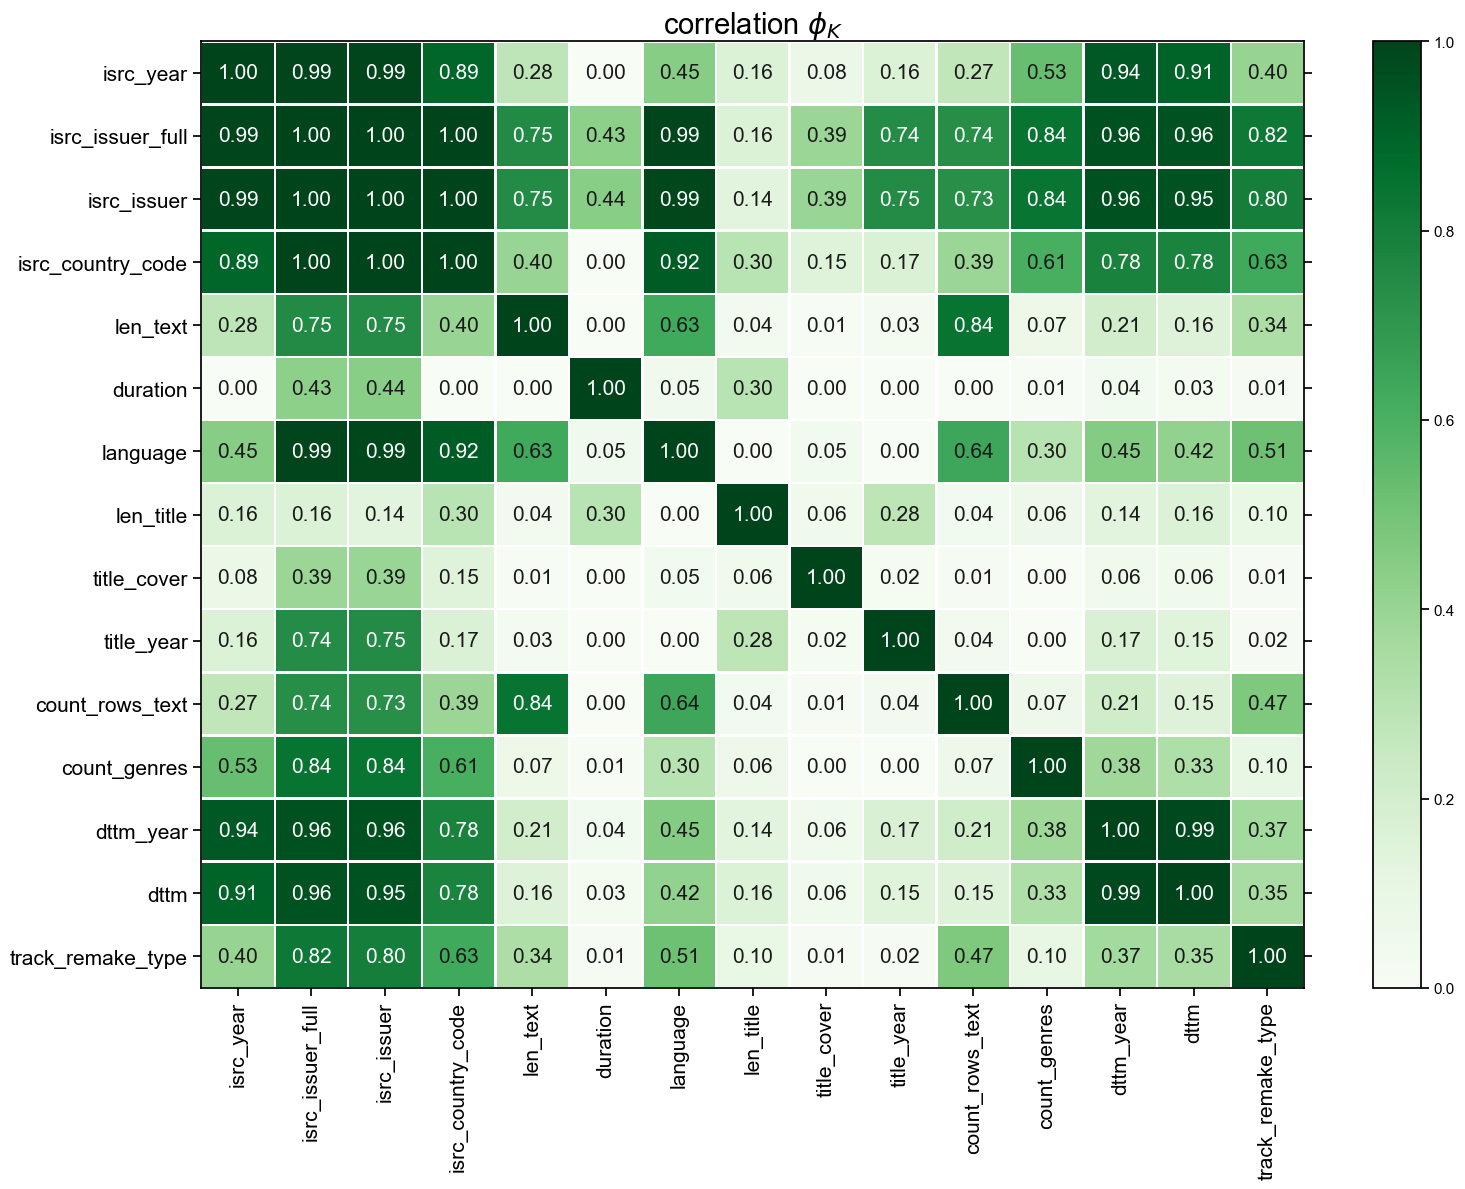

In [114]:
df[['count_rows_text', 'len_text']].fillna(0,  inplace=True)

data_corr = \
    (df[['track_remake_type',
         'dttm',
         'dttm_year',        
         'count_genres',
         'count_rows_text',
         'title_year',
         'title_cover',
         'len_title',
         'language',
         'duration',
         'len_text',
         'isrc_country_code',
         'isrc_issuer',
         'isrc_issuer_full',
         'isrc_year']].phik_matrix(interval_cols=['dttm',
                                                  'duration',
                                                  'len_title',
                                                  'len_text',
                                                  'count_genres',
                                                  'count_rows_text']))
#warnings.filterwarnings('default')

plot_correlation_matrix(data_corr.values,
                        x_labels=data_corr.columns,
                        y_labels=data_corr.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(16, 12))

<u>Вывод:</u><br>
Как видим есть сильная связь между целевой переменной и признаками: ид. эмитента (сокращенной и поолный), код страны, язык, год выпуска).<br>
Присутствует мультиколлинеарность между признаками, сгенерированными из isrc, языком и годом из dttm.<br>
Более корректно эмитента указывать с кодом страны, поэтому признак isrc_issuer будет отброшен.

## Обучение модели определения оригинала трека.

Отберём строки с известными значениями original/cover и поделим на тренировочную и тестовую выборку.<br>
Также отбросим столбец с текстом, названиями песен, известных оригиналах.

In [246]:
df_new = df[~df['track_remake_type'].isna()].drop('text', axis=1)
df_new.shape

(71597, 147)

In [247]:
f_cols = list(set(df_new.columns) - set(['original_track_id', 'track_remake_type']) - set(['title', 'isrc_issuer']))

target = df_new['track_remake_type'].apply(lambda x: 1 if x == 'ORIGINAL' else 0)


features = df_new[f_cols]
features['title_year'] = features['title_year'].astype('str').astype('category')
#features.drop(columns='title_year', inplace=True)


cat_features = list(features.select_dtypes(include=['object', 'category']).columns)
#features[cat_features].astype('object')

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.15, random_state=STATE, stratify=target)





In [248]:
pd.DataFrame.iteritems = pd.DataFrame.items

В качестве модели машинного обучения, воспользуемся CatBoost, который отлично обрабатывает категориальные признаки и не требует предварительного избавления от мультиколлинеарности.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC-ROC Score на тестовых данных: 0.9908571810002854
[Summary Statistics]
Accuracy = 95.86% | Balanced Accuracy = 95.98% | Precision = 97.33% | Recall = 95.86% | F1-Score = 96.30% | fbeta = 96.87%


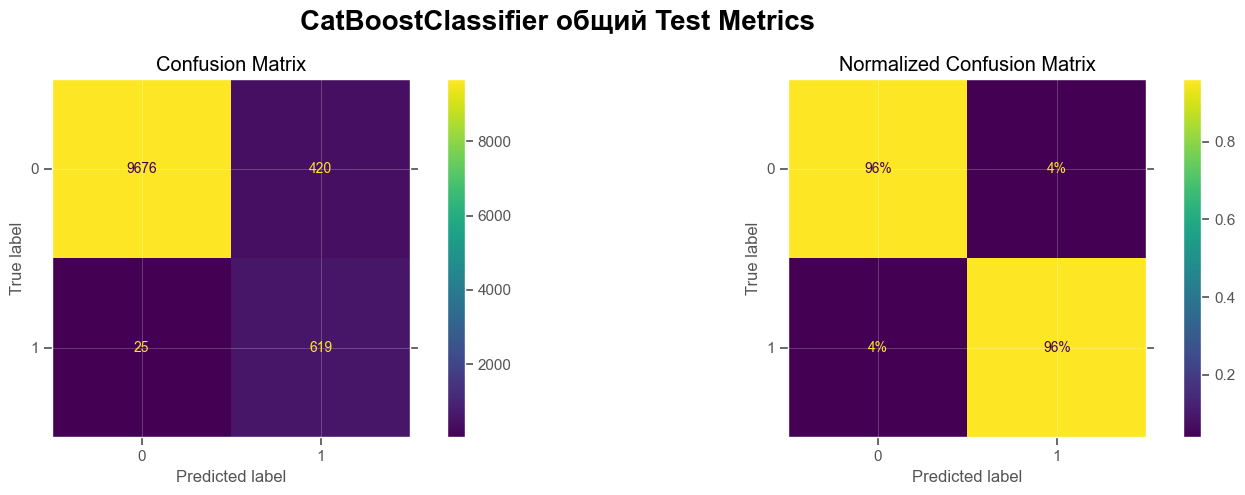


 CatBoostClassifier общий Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     10096
           1       0.60      0.96      0.74       644

    accuracy                           0.96     10740
   macro avg       0.80      0.96      0.86     10740
weighted avg       0.97      0.96      0.96     10740



In [249]:
start_time = time.time()
model_common = CatBoostClassifier(cat_features=cat_features,
                           iterations=400,
                           learning_rate=0.1,
                           depth=7,
                           random_state=STATE,
                           auto_class_weights='Balanced',
                           verbose=False)
model_common.fit(features_train, target_train, eval_set=(features_test,  target_test), plot=True)
predictions = model.predict(features_test)

# AUC-ROC на тестовом наборе
roc_auc = roc_auc_score(target_test, model_common.predict_proba(features_test)[:, 1])
print("AUC-ROC Score на тестовых данных:", roc_auc)
#print("=== Время обучения модели: %s seconds ===" % int(time.time() - start_time))


make_classification_plots(model_common.predict(features_test), target_test, 'CatBoostClassifier общий')

Text(0.5, 1.0, 'Feature Importance')

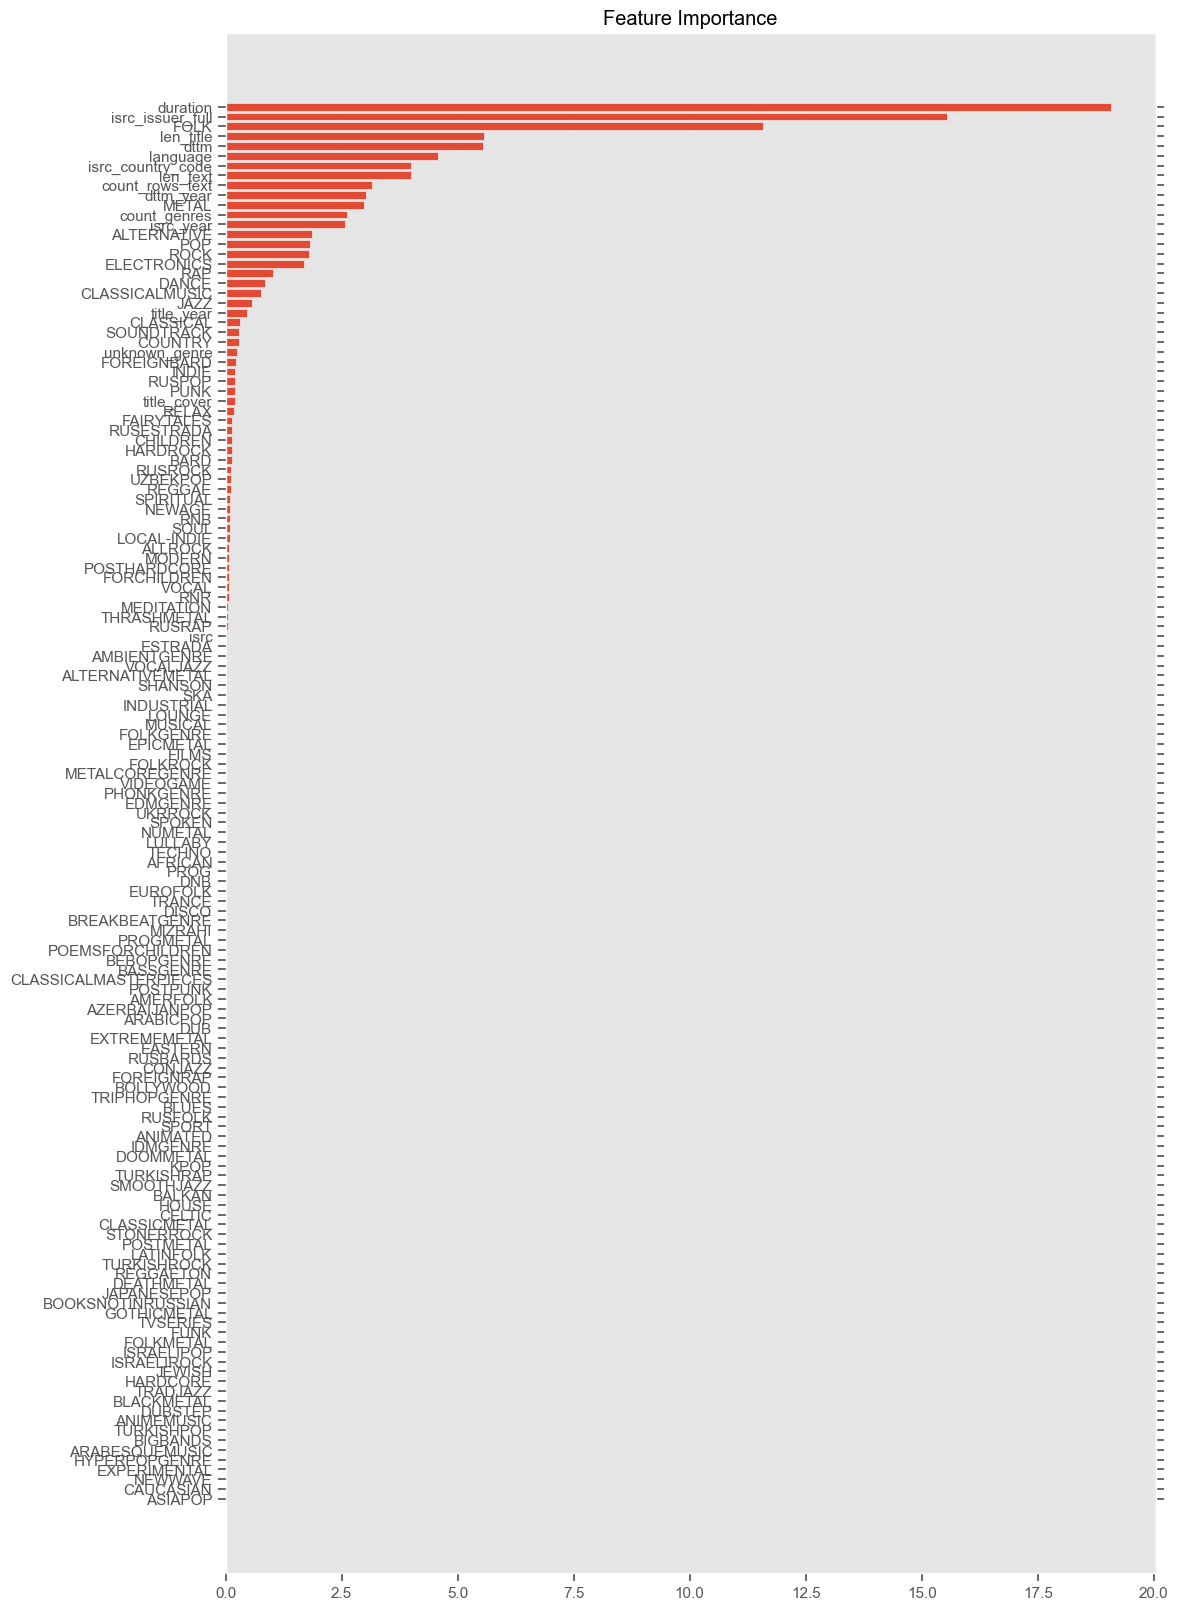

In [250]:
feature_importance = model_common.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


## Отбор самых важных признаков через feature_importance

Отбросим неважные признаки с 0 значением важности и обучим новую модель.

In [251]:
fi_result = pd.DataFrame(feature_importance[sorted_idx], 
                         index=np.array(features_test.columns)[sorted_idx]).sort_values(by=0, ascending=False)
fs = fi_result[fi_result[0] > 0].index
len(fi_result), len(fs)

(143, 93)

In [255]:
target = df_new['track_remake_type'].apply(lambda x: 1 if x == 'ORIGINAL' else 0)
features = df_new[fs]
features['title_year'] = features['title_year'].astype('str').astype('category')

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.15, random_state=STATE, stratify=target)

cat_features = list(features.select_dtypes(include=['object', 'category']).columns)

In [257]:
start_time = time.time()
model_common_1 = CatBoostClassifier(cat_features=cat_features,
                           iterations=400,
                           learning_rate=0.1,
                           depth=7,
                           random_state=STATE,
                           auto_class_weights='Balanced',
                           verbose=False)
model_common_1.fit(features_train, target_train, plot=True)
predictions = model_common_1.predict(features_test)

# Вычислите AUC-ROC на тестовом наборе
roc_auc = roc_auc_score(target_test, model_common_1.predict_proba(features_test)[:, 1])
print("AUC-ROC Score на тестовых данных:", roc_auc)
print("=== Время обучения модели: %s seconds ===" % int(time.time() - start_time))


AUC-ROC Score на тестовых данных: 0.9914300971542754
=== Время обучения модели: 34 seconds ===


[Summary Statistics]
Accuracy = 96.47% | Balanced Accuracy = 95.94% | Precision = 97.54% | Recall = 96.47% | F1-Score = 96.79% | fbeta = 97.20%


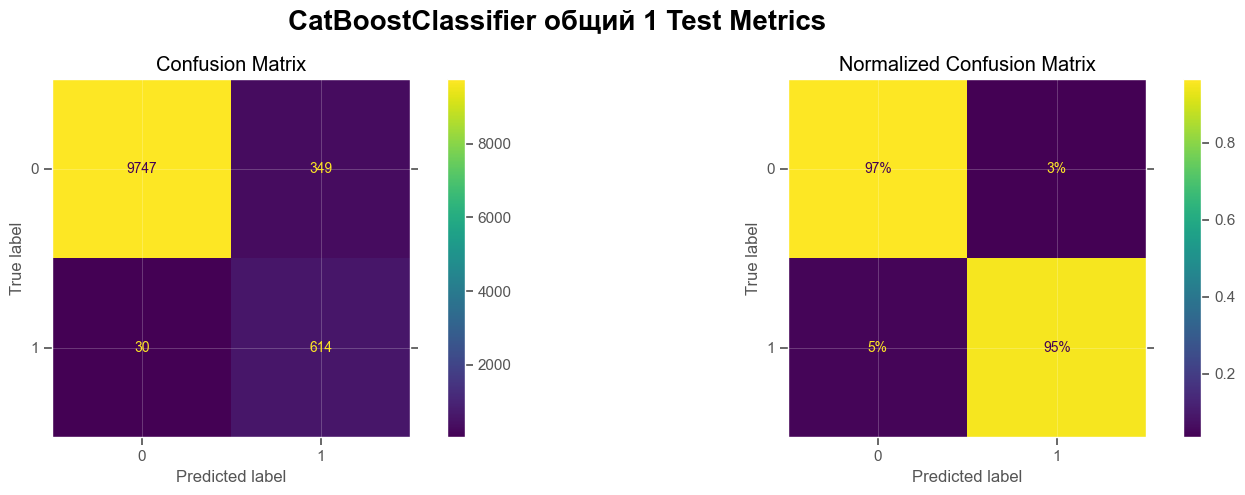


 CatBoostClassifier общий 1 Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     10096
           1       0.64      0.95      0.76       644

    accuracy                           0.96     10740
   macro avg       0.82      0.96      0.87     10740
weighted avg       0.98      0.96      0.97     10740



In [259]:
make_classification_plots(model_common_1.predict(features_test), target_test, 'CatBoostClassifier общий 1')

## Оценка важности признаков с учётом попадания в класс

In [261]:
# Создание объекта Tree Explainer для модели
# explainer = shap.TreeExplainer(model)

# # Расчет SHAP значений
# shap_values = explainer.shap_values(features_test)

# # Визуализация SHAP значений
# shap.summary_plot(shap_values, features_test, feature_names=features_test.columns)

## ВЫВОД по классификации:

Для музыкальных треков из имеющихся данных были созданы 137 новых признаков (129 признаков-жанров), обучена модель на 85% данных с известными значениями столбца 'track_remake_type' и протестирована на оставшихся. Для данной модели не использовалось содержание заголовков и текста песен, а лишь их размер, а также извлекалась возможная полезная информация из заголовков (год и упоминание "cover").<br>
При подборе гиперпараметров модели была поставлена задача добиться максимально качественного поиска оригинала (минимизация ошибки 1-го рода). Также была проведен отбор признаков используя feature_importance и обучена новая модель. Несмотря на то, что метрика улучшилась, до отбора признаков модель совершала меньше ошибок. Метрика качества выбрана AUC-ROC = 0.992 на тестовой выборке. Проведена оценка важности признаков с учётом "попадания в класс". Самыми важными оказались эмитент и длительность трека.<br>
Данная модель корректно работает при условии, что сушествует лишь 2 класса (оригинал и кавер).<br>

# Векторизация текста и поиск ближайших соседей

В данном разделе будут исследованы подходы для векторизации, кластеризации и поиска ближайших соседей. Будут исследован следующий стек:   

    1)CountVectorizer  
    2)TfidfVectorizer  
    3)PCA  
    4)NearestNeighbors  
    5)Faiss  
    6)SBERT

In [262]:
data = upload_data('data/')
test, answer = create_test_data(data)

In [263]:
#Наша метрика, точность нахождения правильного ответа в n кандидатах
def accuracy_at_n(test, data, indexes, answer, return_res=False):
    acc = 0
    for index, target in zip(indexes, test['track_id'].tolist()):
        if answer[target] in data.iloc[index]['track_id'].tolist():
            acc += 1
    if return_res == False:
        print(f"Accuracy@n  = {round(100 * acc / len(test['track_id'].tolist()), 3)}%")
    else:
        return round(100 * acc / len(test['track_id'].tolist()), 3)
    

In [264]:
data['text'] = data['text'].str.replace('\n', ' ')
test['text'] = test['text'].str.replace('\n', ' ')
data['text'] = data['text'].str.lower()
test['text'] = test['text'].str.lower()
data['title'] = data['title'].str.lower()
test['title'] = test['title'].str.lower()

## CountVectorizer + NearestNeighbors

In [265]:
vect = CountVectorizer()
minmax_scale = MinMaxScaler() #Необходимо отмасштабировать данные
vect_base_cv = vect.fit_transform(data['text']).toarray()
vect_base_cv = minmax_scale.fit_transform(vect_base_cv)

In [266]:
test_cv = vect.transform(test['text']).toarray()
test_cv = minmax_scale.transform(test_cv)

In [267]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_cv)
    start_time = time.time()
    dist, ind = nn.kneighbors(test_cv)
    print(f"Время работы модели NearestNeighbors для тестовых данных = {round(time.time() - start_time, 5)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время работы модели NearestNeighbors для тестовых данных = 3.26101 секунд
Точность на тестовой выборке при 5 соседях = 46.078%

Время работы модели NearestNeighbors для тестовых данных = 3.123 секунд
Точность на тестовой выборке при 25 соседях = 85.621%

Время работы модели NearestNeighbors для тестовых данных = 2.965 секунд
Точность на тестовой выборке при 50 соседях = 90.85%



## Проверка метрики на адекватность

In [268]:
#Проверка, кинем смоделированные индексы
accuracy_at_n(test, data, [[i, i+1,i, i+3, i] for i in range(len(test['track_id'].tolist()))], answer)

Accuracy@n  = 0.0%


In [269]:
#Проверка, кинем неверные ответы
fake_answer = {k:a for k, a in zip(list(answer.keys()),
                                   data['track_id'].sample(len(list(answer.keys()))).tolist())}
accuracy_at_n(test, data, ind, fake_answer)

Accuracy@n  = 0.327%


## CountVectorizer + PCA + NearestNeighbors

In [270]:
vect = CountVectorizer()
minmax_scale = MinMaxScaler() #Необходимо отмасштабировать данные
pca = PCA(n_components=1024)

vect_base_cv = vect.fit_transform(data['text']).toarray()
vect_base_cv = minmax_scale.fit_transform(vect_base_cv)
vect_base_cv_pca = pca.fit_transform(vect_base_cv)

In [271]:
test_cv = vect.transform(test['text']).toarray()
test_cv = minmax_scale.transform(test_cv)
test_cv_pca = pca.transform(test_cv)

In [272]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_cv_pca)
    start_time = time.time()
    dist, ind = nn.kneighbors(test_cv_pca)
    print(f"Время работы модели NearestNeighbors для тестовых данных = {round(time.time() - start_time, 5)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время работы модели NearestNeighbors для тестовых данных = 0.061 секунд
Точность на тестовой выборке при 5 соседях = 41.503%

Время работы модели NearestNeighbors для тестовых данных = 0.063 секунд
Точность на тестовой выборке при 25 соседях = 88.562%

Время работы модели NearestNeighbors для тестовых данных = 0.066 секунд
Точность на тестовой выборке при 50 соседях = 92.81%



## TfidfVectorizer + NearestNeighbors

In [273]:
tfidf = TfidfVectorizer()
vect_base_tfidf = tfidf.fit_transform(data['text']).toarray()
test_tfidf = tfidf.transform(test['text']).toarray()

In [274]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_tfidf)
    start_time = time.time()
    dist, ind = nn.kneighbors(test_tfidf)
    print(f"Время работы модели NearestNeighbors для тестовых данных = {round(time.time() - start_time, 5)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время работы модели NearestNeighbors для тестовых данных = 3.147 секунд
Точность на тестовой выборке при 5 соседях = 46.405%

Время работы модели NearestNeighbors для тестовых данных = 2.951 секунд
Точность на тестовой выборке при 25 соседях = 91.503%

Время работы модели NearestNeighbors для тестовых данных = 3.34 секунд
Точность на тестовой выборке при 50 соседях = 98.693%



## TfidfVectorizer + PCA + NearestNeighbors

### Размерность 512

In [275]:
#Переменные vect_base_tfidf и test_tfidf из пункта 6.4
pca_512 = PCA(n_components=512)
start_time = time.time()
vect_base_tfidf_pca_512 = pca_512.fit_transform(vect_base_tfidf)
print(f"Время работы PCA 512 для базы данных = {round(time.time() - start_time, 5)} секунд")

start_time = time.time()
test_tfidf_pca_512 = pca_512.transform(test_tfidf)
print(f"Время работы PCA для test = {round(time.time() - start_time, 5)} секунд")

Время работы PCA 512 для базы данных = 79.094 секунд
Время работы PCA для test = 0.328 секунд


In [276]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_tfidf_pca_512)
    
    start_time = time.time()
    dist, ind = nn.kneighbors(test_tfidf_pca_512)
    print(f"Время поиска {i} соседей методом NearestNeighbors = {round(time.time() - start_time, 5)} секунд")
    
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время поиска 5 соседей методом NearestNeighbors = 0.042 секунд
Точность на тестовой выборке при 5 соседях = 46.732%

Время поиска 25 соседей методом NearestNeighbors = 0.044 секунд
Точность на тестовой выборке при 25 соседях = 85.948%

Время поиска 50 соседей методом NearestNeighbors = 0.04 секунд
Точность на тестовой выборке при 50 соседях = 92.484%



### Размерность 1024

In [277]:
#Переменные vect_base_tfidf и test_tfidf из пункта 6.4
pca_1024 = PCA(n_components=1024)
start_time = time.time()
vect_base_tfidf_pca_1024 = pca_1024.fit_transform(vect_base_tfidf)
print(f"Время работы PCA 1024 для базы данных = {round(time.time() - start_time, 5)} секунд")

start_time = time.time()
test_tfidf_pca_1024 = pca_1024.transform(test_tfidf)
print(f"Время работы PCA для test = {round(time.time() - start_time, 5)} секунд")

Время работы PCA 1024 для базы данных = 142.67875 секунд
Время работы PCA для test = 0.639 секунд


In [278]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_tfidf_pca_1024)
    
    start_time = time.time()
    dist, ind = nn.kneighbors(test_tfidf_pca_1024)
    print(f"Время поиска {i} соседей методом NearestNeighbors = {round(time.time() - start_time, 5)} секунд")
    
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время поиска 5 соседей методом NearestNeighbors = 0.068 секунд
Точность на тестовой выборке при 5 соседях = 46.405%

Время поиска 25 соседей методом NearestNeighbors = 0.064 секунд
Точность на тестовой выборке при 25 соседях = 85.621%

Время поиска 50 соседей методом NearestNeighbors = 0.071 секунд
Точность на тестовой выборке при 50 соседях = 92.484%



### Размерность 2048

In [279]:
#Переменные vect_base_tfidf и test_tfidf из пункта 6.4
pca_2048 = PCA(n_components=2048)
start_time = time.time()
vect_base_tfidf_pca_2048 = pca_2048.fit_transform(vect_base_tfidf)
print(f"Время работы PCA 2048 для базы данных = {round(time.time() - start_time, 5)} секунд")

start_time = time.time()
test_tfidf_pca_2048 = pca_2048.transform(test_tfidf)
print(f"Время работы PCA для test = {round(time.time() - start_time, 5)} секунд")

Время работы PCA 2048 для базы данных = 197.346 секунд
Время работы PCA для test = 0.915 секунд


In [280]:
for i in [5, 25, 50]:
    nn = NearestNeighbors(n_neighbors=i, metric = 'euclidean')
    nn.fit(vect_base_tfidf_pca_2048)
    
    start_time = time.time()
    dist, ind = nn.kneighbors(test_tfidf_pca_2048)
    print(f"Время поиска {i} соседей методом NearestNeighbors = {round(time.time() - start_time, 5)} секунд")
    
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, ind, answer, return_res=True)}%")
    print()

Время поиска 5 соседей методом NearestNeighbors = 0.113 секунд
Точность на тестовой выборке при 5 соседях = 47.059%

Время поиска 25 соседей методом NearestNeighbors = 0.091 секунд
Точность на тестовой выборке при 25 соседях = 90.196%

Время поиска 50 соседей методом NearestNeighbors = 0.103 секунд
Точность на тестовой выборке при 50 соседях = 97.386%



## Faiss 

In [281]:
def train_index_model(faiss_model, vext_data_base):
    start_time = time.time()
    faiss_model.train(np.ascontiguousarray(vext_data_base).astype('float32'))
    faiss_model.add(np.ascontiguousarray(vext_data_base).astype('float32'))
    print(f"Время рассчета индексов для модели с PCA(512) = {round(time.time() - start_time, 6)} секунд")

### Индекс IVFPQ

In [294]:
#Создаём IVFPQ индекс
#Размерность
dims = vect_base_tfidf.shape[1]
#Делитель
quantizer = faiss.IndexFlatL2(dims)
#Создаём индексы
idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, 1000, 1, 6)
#Количество соседних ячеек, куда заходит алгоритм поиска
idx_IVFPQ.nprobe = 50

In [295]:
train_index_model(idx_IVFPQ, vect_base_tfidf)

Время рассчета индексов для модели с PCA(512) = 78.434 секунд


In [297]:
 vecs, idx = idx_IVFPQ.search(np.ascontiguousarray(test_tfidf).astype('float32'), 50)

In [298]:
idx

array([[   87,    88,   761, ...,  7560,  7565,  7936],
       [  140,  7373,   607, ...,  2612,  2641,  2642],
       [  152,   470,   503, ...,   372,   509,   537],
       ...,
       [ 1242,  1631,  2026, ...,  8057,  8058,  8072],
       [ 1718,  4482, 11094, ...,  4483,  4487,  4515],
       [ 1718,  4482, 11094, ...,  4483,  4487,  4515]], dtype=int64)

In [299]:
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFPQ.search(np.ascontiguousarray(test_tfidf).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFPQ = {round(time.time() - start_time, 5)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFPQ = 1.813 секунд
Точность на тестовой выборке при 5 соседях = 44.771%

Время поиска 25 соседей Faiss c индексом IVFPQ = 1.92 секунд
Точность на тестовой выборке при 25 соседях = 82.026%

Время поиска 50 соседей Faiss c индексом IVFPQ = 1.719 секунд
Точность на тестовой выборке при 50 соседях = 89.542%



#### Индекс IVFPQ + PCA(512)

In [301]:
#Создаём IVFPQ индекс
#Размерность
dims = vect_base_tfidf_pca_512.shape[1]
#Делитель
quantizer = faiss.IndexFlatL2(dims)
#Создаём индексы
idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, 1000, 2, 6)
#Количество соседних ячеек, куда заходит алгоритм поиска
idx_IVFPQ.nprobe = 50

In [302]:
#Тренируем модель
start_time = time.time()
idx_IVFPQ.train(np.ascontiguousarray(vect_base_tfidf_pca_512).astype('float32'))
idx_IVFPQ.add(np.ascontiguousarray(vect_base_tfidf_pca_512).astype('float32'))
print(f"Время рассчета индексов для IVFPQ с PCA(512) = {round(time.time() - start_time, 6)} секунд")

Время рассчета индексов для IVFPQ с PCA(512) = 0.904 секунд


In [303]:
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFPQ.search(np.ascontiguousarray(test_tfidf_pca_512).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFPQ = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFPQ = 0.007001 секунд
Точность на тестовой выборке при 5 соседях = 48.693%

Время поиска 25 соседей Faiss c индексом IVFPQ = 0.005999 секунд
Точность на тестовой выборке при 25 соседях = 84.641%

Время поиска 50 соседей Faiss c индексом IVFPQ = 0.006 секунд
Точность на тестовой выборке при 50 соседях = 90.196%



#### Индекс IVFPQ + PCA(1024)

In [304]:
#Создаём IVFPQ индекс
#Размерность
dims = vect_base_tfidf_pca_1024.shape[1]
#Делитель
quantizer = faiss.IndexFlatL2(dims)
#Создаём индексы
idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, 1000, 2, 6)
#Количество соседних ячеек, куда заходит алгоритм поиска
idx_IVFPQ.nprobe = 50

In [305]:
#Тренируем модель
start_time = time.time()
idx_IVFPQ.train(np.ascontiguousarray(vect_base_tfidf_pca_1024).astype('float32'))
idx_IVFPQ.add(np.ascontiguousarray(vect_base_tfidf_pca_1024).astype('float32'))
print(f"Время рассчета индексов для IVFPQ с PCA(1024) = {round(time.time() - start_time, 6)} секунд")

Время рассчета индексов для IVFPQ с PCA(1024) = 1.404 секунд


In [306]:
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFPQ.search(np.ascontiguousarray(test_tfidf_pca_1024).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFPQ = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFPQ = 0.010001 секунд
Точность на тестовой выборке при 5 соседях = 45.098%

Время поиска 25 соседей Faiss c индексом IVFPQ = 0.008 секунд
Точность на тестовой выборке при 25 соседях = 85.621%

Время поиска 50 соседей Faiss c индексом IVFPQ = 0.009 секунд
Точность на тестовой выборке при 50 соседях = 90.85%



#### Индекс IVFPQ + PCA(2048)

In [307]:
#Создаём IVFPQ индекс
#Размерность
dims = vect_base_tfidf_pca_2048.shape[1]
#Делитель
quantizer = faiss.IndexFlatL2(dims)
#Создаём индексы
idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, 1000, 2, 6)
#Количество соседних ячеек, куда заходит алгоритм поиска
idx_IVFPQ.nprobe = 50

In [308]:
#Тренируем модель
start_time = time.time()
idx_IVFPQ.train(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))
idx_IVFPQ.add(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))
print(f"Время рассчета индексов для IVFPQ с PCA(1024) = {round(time.time() - start_time, 6)} секунд")

Время рассчета индексов для IVFPQ с PCA(1024) = 2.541999 секунд


In [309]:
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFPQ.search(np.ascontiguousarray(test_tfidf_pca_2048).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFPQ = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFPQ = 0.014999 секунд
Точность на тестовой выборке при 5 соседях = 46.078%

Время поиска 25 соседей Faiss c индексом IVFPQ = 0.013 секунд
Точность на тестовой выборке при 25 соседях = 82.68%

Время поиска 50 соседей Faiss c индексом IVFPQ = 0.014 секунд
Точность на тестовой выборке при 50 соседях = 89.869%



### IndexIVFFlat

In [310]:
dims = vect_base_tfidf.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_IVFFlat = faiss.IndexIVFFlat(quantizer, dims, 1000, faiss.METRIC_L2) #METRIC_L2
idx_IVFFlat.nprobe = 50

In [311]:
#Тренируем модель
idx_IVFFlat.train(np.ascontiguousarray(vect_base_tfidf).astype('float32'))
idx_IVFFlat.add(np.ascontiguousarray(vect_base_tfidf).astype('float32'))

In [312]:
#Ищем ответы для теста
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFFlat.search(np.ascontiguousarray(test_tfidf).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFFlat = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFFlat = 9.852 секунд
Точность на тестовой выборке при 5 соседях = 45.098%

Время поиска 25 соседей Faiss c индексом IVFFlat = 8.876 секунд
Точность на тестовой выборке при 25 соседях = 87.908%

Время поиска 50 соседей Faiss c индексом IVFFlat = 8.524 секунд
Точность на тестовой выборке при 50 соседях = 95.098%



#### IndexIVFFlat + PCA(2048)

In [313]:
dims = vect_base_tfidf_pca_2048.shape[1]
quantizer = faiss.IndexFlatL2(dims)
idx_IVFFlat = faiss.IndexIVFFlat(quantizer, dims, 1000, faiss.METRIC_L2) #METRIC_L2
idx_IVFFlat.nprobe = 50

In [314]:
#Тренируем модель
idx_IVFFlat.train(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))
idx_IVFFlat.add(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))

In [315]:
#Ищем ответы для теста
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IVFFlat.search(np.ascontiguousarray(test_tfidf_pca_2048).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFFlat = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFFlat = 0.220998 секунд
Точность на тестовой выборке при 5 соседях = 46.405%

Время поиска 25 соседей Faiss c индексом IVFFlat = 0.207 секунд
Точность на тестовой выборке при 25 соседях = 87.582%

Время поиска 50 соседей Faiss c индексом IVFFlat = 0.207001 секунд
Точность на тестовой выборке при 50 соседях = 94.444%



### IndexIMIFlat

####  PCA(512)

In [396]:
dims = vect_base_tfidf_pca_512.shape[1]

M_mi = 2
nbits_mi = 6
ncentroids_mi = 2 ** (M_mi * nbits_mi)
coarse_quantizer_mi = faiss.MultiIndexQuantizer(dims, M_mi, nbits_mi)


idx_IMIFlat_512 = faiss.IndexIVFFlat(coarse_quantizer_mi, dims, ncentroids_mi, faiss.METRIC_L2) #METRIC_L2
idx_IMIFlat_512.nprobe = 200
idx_IMIFlat_512.quantizer_trains_alone = True

In [397]:
#Тренируем модель
idx_IMIFlat_512.train(np.ascontiguousarray(vect_base_tfidf_pca_512).astype('float32'))
idx_IMIFlat_512.add(np.ascontiguousarray(vect_base_tfidf_pca_512).astype('float32'))

In [398]:
#Ищем ответы для теста
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IMIFlat_512.search(np.ascontiguousarray(test_tfidf_pca_512).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IVFFlat = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IVFFlat = 0.020001 секунд
Точность на тестовой выборке при 5 соседях = 46.078%

Время поиска 25 соседей Faiss c индексом IVFFlat = 0.022002 секунд
Точность на тестовой выборке при 25 соседях = 83.66%

Время поиска 50 соседей Faiss c индексом IVFFlat = 0.017 секунд
Точность на тестовой выборке при 50 соседях = 89.542%



#### PCA(2048)

In [399]:
dims = vect_base_tfidf_pca_2048.shape[1]

M_mi = 2
nbits_mi = 6
ncentroids_mi = 2 ** (M_mi * nbits_mi)
coarse_quantizer_mi = faiss.MultiIndexQuantizer(dims, M_mi, nbits_mi)


idx_IMIFlat_2048 = faiss.IndexIVFFlat(coarse_quantizer_mi, dims, ncentroids_mi, faiss.METRIC_L2) #METRIC_L2
idx_IMIFlat_2048.nprobe = 1000
idx_IMIFlat_2048.quantizer_trains_alone = True

In [400]:
#Тренируем модель
idx_IMIFlat_2048.train(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))
idx_IMIFlat_2048.add(np.ascontiguousarray(vect_base_tfidf_pca_2048).astype('float32'))

In [401]:
#Ищем ответы для теста
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IMIFlat_2048.search(np.ascontiguousarray(test_tfidf_pca_2048).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IMIFlat = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IMIFlat = 0.603999 секунд
Точность на тестовой выборке при 5 соседях = 46.405%

Время поиска 25 соседей Faiss c индексом IMIFlat = 0.577 секунд
Точность на тестовой выборке при 25 соседях = 90.196%

Время поиска 50 соседей Faiss c индексом IMIFlat = 0.563001 секунд
Точность на тестовой выборке при 50 соседях = 97.386%



## Multi language embedded and SBERT (Векторизация)

Основная идея была в том что найти предобученный трансформер и его использовать для создание embedding и на основании делать кластеризацию  

С помощью SentenceTransformer('all-MiniLM-L6-v2') мы определяем, какую модель трансформатора предложений мы хотим загрузить. В данном примере мы загружаем модель all-MiniLM-L6-v2, которая представляет собой модель MiniLM, точно настроенную на большом наборе данных, содержащем более 1 млрд. обучающих пар.

BERT (и другие сети-трансформаторы) для каждой лексемы во входном тексте выдают вставку. Для того чтобы создать из него вложение предложения фиксированного размера, модель применяет метод объединения средних, т.е. выходные вложения для всех лексем усредняются, чтобы получить вектор фиксированного размера.Основное преимущество такого подход, по мимо лучшего улавливание смысла, это общие встроенных предложений для разных языков

In [322]:
#!pip install -U sentence-transformers
#!pip install diameter-clustering

In [323]:
from sentence_transformers import SentenceTransformer, util
sbert = SentenceTransformer('all-MiniLM-L6-v2')

In [324]:
# получаем встроенный текст (считает ~10 минут)
embed_data = sbert.encode(list(data['text']), convert_to_tensor=True)
embed_data

tensor([[-0.0127, -0.0585,  0.0210,  ...,  0.0321, -0.0568, -0.0869],
        [ 0.0264,  0.0291,  0.0295,  ..., -0.0332, -0.0312,  0.0054],
        [-0.0267, -0.0676,  0.0953,  ...,  0.0112, -0.0242, -0.0464],
        ...,
        [ 0.0540,  0.0235,  0.0337,  ...,  0.0066, -0.0273, -0.0802],
        [ 0.0540,  0.0235,  0.0337,  ...,  0.0066, -0.0273, -0.0802],
        [ 0.0076,  0.0050,  0.0578,  ...,  0.0597, -0.1150, -0.0753]])

In [325]:
embed_data.shape

torch.Size([11097, 384])

### IMIFlat + SBERT

In [328]:
embed_test = embed_data[list(test.index)]

In [331]:
dims = embed_data.shape[1]

M_mi = 2
nbits_mi = 6
ncentroids_mi = 2 ** (M_mi * nbits_mi)
coarse_quantizer_mi = faiss.MultiIndexQuantizer(dims, M_mi, nbits_mi)


idx_IMIFlat = faiss.IndexIVFFlat(coarse_quantizer_mi, dims, ncentroids_mi, faiss.METRIC_L2) #METRIC_L2
idx_IMIFlat.nprobe = 200
idx_IMIFlat.quantizer_trains_alone = True

In [332]:
#Тренируем модель
idx_IMIFlat.train(np.ascontiguousarray(embed_data).astype('float32'))
idx_IMIFlat.add(np.ascontiguousarray(embed_data).astype('float32'))

In [333]:
#Ищем ответы для теста
for i in [5, 25, 50]:
    start_time = time.time()
    vecs, idx = idx_IMIFlat.search(np.ascontiguousarray(embed_test).astype('float32'), i)
    print(f"Время поиска {i} соседей Faiss c индексом IMIFlat = {round(time.time() - start_time, 6)} секунд")
    print(f"Точность на тестовой выборке при {i} соседях = {accuracy_at_n(test, data, idx, answer, return_res=True)}%")
    print()

Время поиска 5 соседей Faiss c индексом IMIFlat = 0.009 секунд
Точность на тестовой выборке при 5 соседях = 48.039%

Время поиска 25 соседей Faiss c индексом IMIFlat = 0.007002 секунд
Точность на тестовой выборке при 25 соседях = 93.137%

Время поиска 50 соседей Faiss c индексом IMIFlat = 0.008002 секунд
Точность на тестовой выборке при 50 соседях = 96.405%



### fast_clustering

**Расчет на основании косинусного сходства**

Вы можете задать порог косинусного сходства, при котором два предложения считаются похожими. Также можно задать минимальный размер локального сообщества. Это позволяет получать как крупные крупнозернистые кластеры, так и мелкие мелкозернистые кластеры.



https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py

In [342]:
print("Start clustering")
start_time = time.time()

#Two parameters to tune:
#min_cluster_size: Only consider cluster that have at least 25 elements
#threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(embed_data, min_community_size=25, threshold=0.75)

print("Clustering done after {:.2f} sec".format(time.time() - start_time))

Start clustering
Clustering done after 24.98 sec


In [343]:
#Print for all clusters the top 3 and bottom 3 elements
# for i, cluster in enumerate(clusters):
#     print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
#     for sentence_id in cluster[0:3]:
#         print("\t", text[sentence_id])
#     print("\t", "...")
#     for sentence_id in cluster[-3:]:
#         print("\t", text[sentence_id])

In [345]:
#Compute cosine-similarities
cosine_scores = util.cos_sim(embed_data, embed_data)
cosine_scores

tensor([[1.0000, 0.1012, 0.1748,  ..., 0.0712, 0.0712, 0.7622],
        [0.1012, 1.0000, 0.3028,  ..., 0.2279, 0.2279, 0.0546],
        [0.1748, 0.3028, 1.0000,  ..., 0.2995, 0.2995, 0.1199],
        ...,
        [0.0712, 0.2279, 0.2995,  ..., 1.0000, 1.0000, 0.0168],
        [0.0712, 0.2279, 0.2995,  ..., 1.0000, 1.0000, 0.0168],
        [0.7622, 0.0546, 0.1199,  ..., 0.0168, 0.0168, 1.0000]])

### AgglomerativeClustering

Классический алгоритм для встроенных предложений от трасформера

In [346]:
# нормализация для евклидова расстояния
import torch
import torch.nn.functional as F
from sklearn.cluster import AgglomerativeClustering

normalized_embeddings = F.normalize(embed_data, p=2, dim=1)
normalized_embeddings_np = normalized_embeddings.cpu().numpy()

In [347]:
# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(normalized_embeddings_np)
cluster_assignment = clustering_model.labels_
cluster_assignment

array([474, 685,  23, ..., 383, 383, 836], dtype=int64)

In [361]:
lyrics = pd.DataFrame(cluster_assignment)
lyrics.columns = ['agglomerative_clustering']

### Leader-cosine-clustering

Алгоритм Leader - это инкрементный алгоритм кластеризации, обычно используемый для кластеризации больших массивов данных. Этот алгоритм является порядкозависимым и может формировать различные кластеры в зависимости от того, в каком порядке набор данных предоставляется алгоритму. Алгоритм состоит из следующих шагов.

Шаг 1. Назначить первый элемент данных P1 в кластер C1. Этот набор данных будет являться лидером кластера C1.

Шаг 2: Переходим к следующему элементу данных P2 и вычисляем его расстояние от лидера P1. Если расстояние между P2 и лидером P1 меньше заданного пользователем порога (t), то точка данных P2 будет отнесена к этому кластеру (кластер C1). Если расстояние между лидером P1 и пунктом данных P2 больше заданного пользователем порога t, то формируется новый кластер C2 и P2 назначается в этот новый кластер. P2 будет являться лидером кластера C2.

Шаг 3. Для всех оставшихся элементов данных вычисляется расстояние между точкой данных и лидером кластера. Если расстояние между элементами данных и любым из лидеров меньше заданного пользователем порога, то точка данных будет отнесена к этому кластеру. Если же расстояние между точкой данных и любым из лидеров кластера больше заданного пользователем порога, то создается новый кластер, и данная точка данных назначается в этот кластер и считается лидером кластера.

Шаг 4. Повторяем шаг 3 до тех пор, пока все элементы данных не будут распределены по кластерам.

Фишка в том, что считается на основании косинусовой схожести  
https://github.com/antklen/diameter-clustering  

В теории этот алгоритм решает проблему кавер/не кавер. Так как находит наиболее похожие по косинусу на основании лидера класса и уже выстраивает кластеризацию. Поэтому кавер/некавер можно включать и выключать принадлежностью кластеру

In [362]:
from diameter_clustering import LeaderClustering

model = LeaderClustering(max_radius=0.15, metric='cosine')
labels_leader = model.fit_predict(embed_data.cpu().numpy())
lyrics['leader'] = labels_leader

LeaderClustering fit: 100%|████████████████████████████████████████████████████| 11096/11096 [00:02<00:00, 4955.78it/s]


In [363]:
lyrics.to_csv("sbert_calstering.csv")

In [365]:
lyrics[lyrics['agglomerative_clustering'] == 437 ]

,agglomerative_clustering,leader
603,437,633
604,437,633
4447,437,812


In [367]:
# for i in lyrics[lyrics['agglomerative_clustering'] == 437 ][:10].index:
#     print(lyrics.loc[i,'text'][:200])
#     print("__________________________________")

## Результаты

<table>
    <tr>
        <td>Модель</td>
        <td>accuracy@5</td>
        <td>accuracy@25</td>
        <td>accuracy@50</td>
        <td>Время (n=5)</td>
        <td>Время (n=25)</td>
        <td>Время (n=50) </td>
    </tr>
    <tr>
        <td>CountVectorizer + NearestNeighbors</td>
        <td>46,078</td>
        <td>85,621</td>
        <td>90,85</td>
        <td>62,369</td>
        <td>61,886</td>
        <td>62,99899 </td>
    </tr>
    <tr>
        <td>CountVectorizer + PCA(1024) + NearestNeighbors</td>
        <td>41,83</td>
        <td>88,562</td>
        <td>92,81</td>
        <td>0,223</td>
        <td>0,225</td>
        <td>0,208 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + NearestNeighbors</td>
        <td>46,405</td>
        <td>91,503</td>
        <td>98,693</td>
        <td>62,05017</td>
        <td>63,7106</td>
        <td>62,01344 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(512) + NearestNeighbors</td>
        <td>46,732</td>
        <td>85,948</td>
        <td>92,484</td>
        <td>0,223</td>
        <td>0,225</td>
        <td>0,208 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(1024) + NearestNeighbors</td>
        <td>46,078</td>
        <td>85,621</td>
        <td>92,157</td>
        <td>0,44</td>
        <td>0,422</td>
        <td>0,44 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(2048) + NearestNeighbors</td>
        <td>46,078</td>
        <td>90,196</td>
        <td>97,386</td>
        <td>0,937</td>
        <td>0,942</td>
        <td>0,927 </td>
    </tr>
    <tr>
        <td> Faiss(IVFPQ)</td>
        <td>44,771</td>
        <td>82,026</td>
        <td>89,542</td>
        <td>1,86755</td>
        <td>1,533</td>
        <td>1,599 </td>
    </tr>
    <tr>
        <td>PCA(512) +  Faiss(IVFPQ)</td>
        <td>46,405</td>
        <td>84,641</td>
        <td>89,869</td>
        <td>0,005</td>
        <td>0,006</td>
        <td>0,006 </td>
    </tr>
    <tr>
        <td>PCA(1024) +  Faiss(IVFPQ)</td>
        <td>42,484</td>
        <td>86,275</td>
        <td>90,85</td>
        <td>0,008999</td>
        <td>0,009001</td>
        <td>0,008 </td>
    </tr>
    <tr>
        <td>PCA(2048) +  Faiss(IVFPQ)</td>
        <td>46,405</td>
        <td>84,967</td>
        <td>90,85</td>
        <td>0,020998</td>
        <td>0,017999</td>
        <td>0,014 </td>
    </tr>
    <tr>
        <td>Faiss(IndexIVFFlat)</td>
        <td>45,098</td>
        <td>87,908</td>
        <td>95,098</td>
        <td>9,099564</td>
        <td>9,483988</td>
        <td>9,907769 </td>
    </tr>
    <tr>
        <td>PCA(2048) + Faiss(IndexIVFFlat)</td>
        <td>46,405</td>
        <td>87,908</td>
        <td>94,771</td>
        <td>0,206999</td>
        <td>0,226941</td>
        <td>0,189997 </td>
    </tr>
    <tr>
        <td>PCA(512) + Faiss(IndexIMIFlat)</td>
        <td>46,078</td>
        <td>83,333</td>
        <td>89,216</td>
        <td>0,021999</td>
        <td>0,019998</td>
        <td>0,024 </td>
    </tr>
    <tr>
        <td>PCA(2048) + Faiss(IndexIMIFlat)</td>
        <td>46,405</td>
        <td>90,196</td>
        <td>97,386</td>
        <td>0,588001</td>
        <td>0,546999</td>
        <td>0,541 </td>
    </tr>
        <tr>
        <td>SBERT + Faiss(IndexIMIFlat)</td>
        <td>48,039</td>
        <td>93,137</td>
        <td>96,405</td>
        <td>0,011999</td>
        <td>0,008004</td>
        <td>0,007999 </td>
    </tr>
</table>

# Ранжирование

## Формируем валиадционную выборку для ранжирования

In [421]:
def creat_valid_data_tfidf(data, n):
    valid_data = data.sample(n)
    valid_data_tfidf = tfidf.transform(valid_data['text']).toarray()
    valid_data_tfidf_pca = pca_512.transform(valid_data_tfidf)
    return valid_data_tfidf_pca

## Подготовка данных

In [422]:
def find_NN(faiss_model, data, n):
    vecs, idx = faiss_model.search(np.ascontiguousarray(data).astype('float32'), n)
    return vecs, idx

### Подготовка данных схожести по тексту 

In [477]:
def creat_similar_text_matrix(data, idx):
    similar_text_matrix = np.array([])
    for i in idx:
        tfidf_part2 = TfidfVectorizer()
        matrix_part2 = cosine_similarity(tfidf_part2.fit_transform(data.iloc[i]['text']).toarray())
        similar_text_matrix = np.concatenate((similar_text_matrix, matrix_part2), axis=0) if   \
                                similar_text_matrix.size != 0 else matrix_part2
        
    similar_text_matrix_sum = pd.DataFrame(similar_text_matrix).sum(axis=1)
    similar_text_matrix_sum = pd.DataFrame(similar_text_matrix_sum)
    similar_text_matrix_sum.columns = ['similarity_text_sum']
    
    similar_text_matrix = pd.DataFrame(similar_text_matrix)
    similar_text_matrix.columns = [f'text_{i}' for i in range(len(i))]
    similar_text_matrix = pd.concat([similar_text_matrix, similar_text_matrix_sum], axis=1)
    return similar_text_matrix#similar_text_matrix_sum

### Подготовка данных схожести по названию

In [478]:
def creat_similar_title_matrix(data, idx):
    similar_title_matrix = np.array([])
    for i in idx:
        tfidf_part2 = TfidfVectorizer()
        matrix_part2 = cosine_similarity(tfidf_part2.fit_transform(data.iloc[i]['title']).toarray())
        similar_title_matrix = np.concatenate((similar_title_matrix, matrix_part2), axis=0) if   \
                                similar_title_matrix.size != 0 else matrix_part2
        
    similar_title_matrix_sum = pd.DataFrame(similar_title_matrix).sum(axis=1)
    similar_title_matrix_sum = pd.DataFrame(similar_title_matrix_sum)
    similar_title_matrix_sum.columns = ['similarity_title_sum']
    
    similar_title_matrix = pd.DataFrame(similar_title_matrix)
    similar_title_matrix.columns = [f'title_{i}' for i in range(len(i))]
    similar_title_matrix = pd.concat([similar_title_matrix, similar_title_matrix_sum], axis=1)
    return similar_title_matrix #similar_title_matrix_sum

### Кодирование

In [425]:
def le_encoder(data):
    le = LabelEncoder()
    data['track_remake_type'] = le.fit_transform(data['track_remake_type'])
    data['isrc_issuer'] = le.fit_transform(data['isrc_issuer'])
    data['isrc_country_code'] = le.fit_transform(data['isrc_country_code'])
    data[ 'language'] = le.fit_transform(data['language'])

### Формирование выборки

In [466]:
def create_data_for_catboost(data, samples, nn):
    valid_vec = creat_valid_data_tfidf(data, samples)
    vecs, idx = find_NN(idx_IMIFlat_512, valid_vec, nn)
    similar_text_matrix = creat_similar_text_matrix(data, idx)
    similar_title_matrix = creat_similar_title_matrix(data, idx)
    idx = [item for sublist in idx for item in sublist]
    data_rng = data.iloc[idx].reset_index(drop=True)
    data_rng['vecs'] = [item for sublist in vecs for item in sublist]
    #data_rng['old_index'] = idx
    data_rng = pd.concat([data_rng, similar_text_matrix, similar_title_matrix], axis=1)
    data_rng.drop(columns=['title', 'genres', 'text', 'isrc'], inplace = True)
    #le_encoder(data_rng)
    
    #title_columns = [i for i in data_rng.columns if 'title' in i]
    #data_rng = data_rng[data_rng['similarity_title_sum'] >= 1.1]
    
    target = data_rng['track_remake_type']
    features =  data_rng.drop(columns='track_remake_type')
    return features, target

## CatBoost

In [427]:
def make_classification_plots(model_preds, y_test, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    cm_matrix = confusion_matrix(y_test, model_preds)

    # 1 - Summary Statistics
    accuracy = accuracy_score(y_test, model_preds) # % positive out of all predicted positives
    balanced_accuracy = balanced_accuracy_score(y_test, model_preds)
    precision = precision_score(y_test, model_preds, average='weighted') # % positive out of all predicted positives
    recall =  recall_score(y_test, model_preds, average='weighted') # % positive out of all supposed to be positives
    f1 = f1_score(y_test, model_preds, average='weighted')
    fbeta = fbeta_score(y_test, model_preds, beta = 0.5, average = 'weighted')
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Balanced Accuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | F1-Score = {:.2%} | fbeta = {:.2%}'.format(accuracy, balanced_accuracy , precision, recall, f1, fbeta)
    print(stats_summary)

    # 2 : Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[0])
    axes[0].set_title("Confusion Matrix")

    # 3 : Normalized Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, model_preds, ax=axes[1], normalize="true", values_format=".0%")
    axes[1].set_title("Normalized Confusion Matrix")

    fig.suptitle(f"{title} Test Metrics", fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 4 : Classification Report
    class_report = classification_report(y_test, model_preds)
    print('\n', f"{title} Classification Report: \n {class_report}")

    plt.style.use('ggplot')

In [428]:
#data['isrc_year'] = data['isrc_year'].astype('int')


In [484]:
X_train, y_train = create_data_for_catboost(data, 300, 50)
X_test, y_test = create_data_for_catboost(data, 50, 50)

In [485]:
X_train = X_train[~X_train['track_id'].isin(set(X_train['track_id']) & set(X_test['track_id']))]

In [486]:
y_train = y_train.loc[X_train.index]

In [487]:
X_train.shape

(6698, 223)

In [488]:
X_train.drop(columns='track_id', inplace=True)

In [489]:
X_test.drop(columns='track_id', inplace=True)

In [490]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [491]:
params = {
    'subsample': 0.4,
    'max_depth': 7,
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'thread_count': 20,
    'random_state': 42,#'class_weights':  class_weights,              
    'boosting_type': 'Ordered',
    'thread_count': -1,
    'l2_leaf_reg': 3.0,
    'verbose': 100,
    'custom_metric': ['AUC', 'Accuracy'],
    'eval_metric' : 'Accuracy',
    'use_best_model': True,
    'cat_features': ['language', 'isrc_country_code', 'isrc_issuer', 'isrc_issuer_full'],
}

model = CatBoostClassifier(**params)

In [492]:
model.fit(X_train, y_train, eval_set=(X_test,  y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8141366	test: 0.7356161	best: 0.7356161 (0)	total: 114ms	remaining: 5m 41s
100:	learn: 0.8765663	test: 0.8291904	best: 0.8291904 (96)	total: 12.5s	remaining: 5m 59s
200:	learn: 0.8923719	test: 0.8361110	best: 0.8385662 (161)	total: 24.8s	remaining: 5m 45s
300:	learn: 0.9124117	test: 0.8420874	best: 0.8428555 (291)	total: 37.2s	remaining: 5m 33s
400:	learn: 0.9201550	test: 0.8460745	best: 0.8460745 (399)	total: 49.2s	remaining: 5m 18s
500:	learn: 0.9260658	test: 0.8488319	best: 0.8488319 (496)	total: 1m 1s	remaining: 5m 4s
600:	learn: 0.9312457	test: 0.8460620	best: 0.8488319 (496)	total: 1m 12s	remaining: 4m 50s
700:	learn: 0.9338606	test: 0.8415966	best: 0.8488319 (496)	total: 1m 24s	remaining: 4m 37s
800:	learn: 0.9376271	test: 0.8417435	best: 0.8488319 (496)	total: 1m 36s	remaining: 4m 25s
900:	learn: 0.9429629	test: 0.8352887	best: 0.8488319 (496)	total: 1m 49s	remaining: 4m 14s
1000:	learn: 0.9506518	test: 0.8349740	best: 0.8488319 (496)	total: 2m 1s	remaining: 4m 2s
1

[Summary Statistics]
Accuracy = 88.28% | Balanced Accuracy = 82.87% | Precision = 88.53% | Recall = 88.28% | F1-Score = 88.39% | fbeta = 88.47%


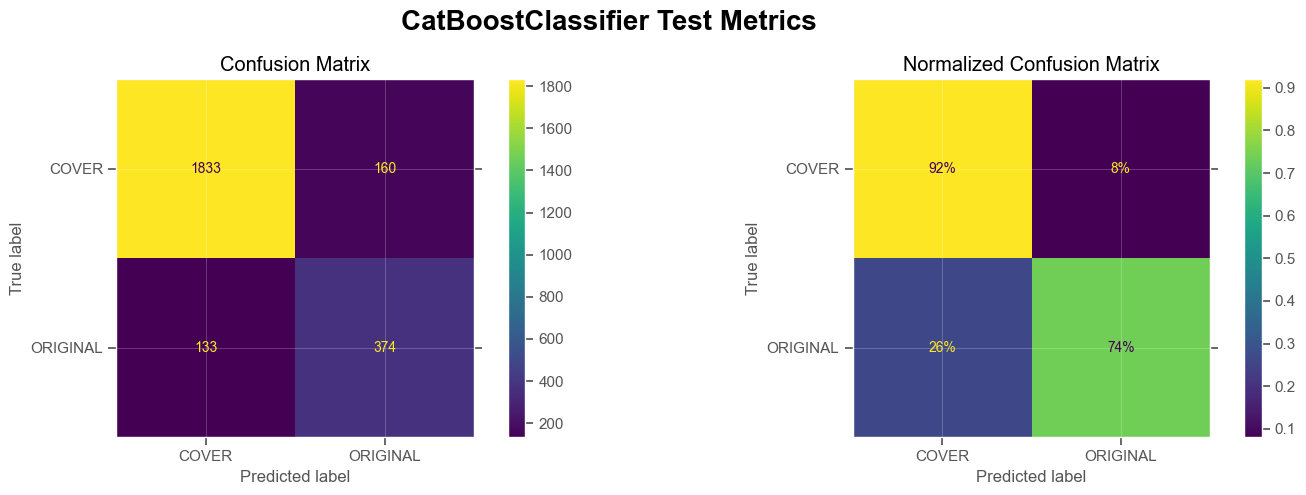


 CatBoostClassifier Classification Report: 
               precision    recall  f1-score   support

       COVER       0.93      0.92      0.93      1993
    ORIGINAL       0.70      0.74      0.72       507

    accuracy                           0.88      2500
   macro avg       0.82      0.83      0.82      2500
weighted avg       0.89      0.88      0.88      2500



In [493]:
make_classification_plots(model.predict(X_test), y_test, 'CatBoostClassifier')

Text(0.5, 1.0, 'CatBoostClassifier Feature Importance')

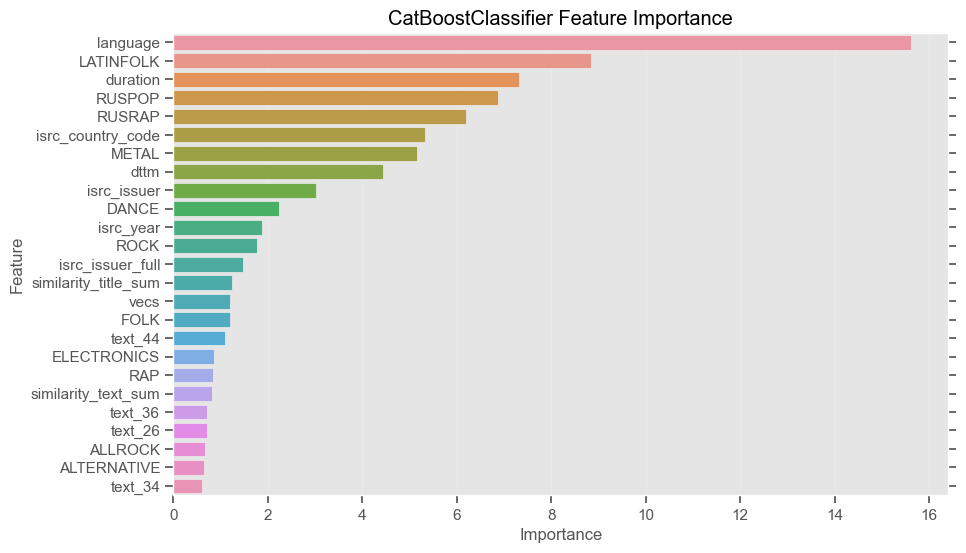

In [494]:
results = list(zip(X_test, model.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)

se.barplot(x = importance.Importance[:25], y = importance.Feature[:25])
plt.title("CatBoostClassifier Feature Importance")

## Тестирование модели

In [480]:
vecs, idx = find_NN(idx_IMIFlat, test_tfidf_pca_512, 50)
similar_text_matrix = creat_similar_text_matrix(data, idx)
similar_title_matrix = creat_similar_title_matrix(data, idx)
idx = [item for sublist in idx for item in sublist]
data_rng = data.iloc[idx].reset_index(drop=True)
data_rng['vecs'] = [item for sublist in vecs for item in sublist]
#data_rng['old_index'] = idx
data_rng = pd.concat([data_rng, similar_text_matrix, similar_title_matrix], axis=1)
data_rng.drop(columns=['title', 'genres', 'text', 'track_id', 'isrc'], inplace = True)
#data_rng = data_rng[data_rng['similarity_title_sum'] >= 1.1]
#le_encoder(data_rng)

In [481]:
data_rng.shape

(15300, 223)

In [482]:
target = data_rng['track_remake_type']
data_rng.drop(columns='track_remake_type', inplace=True)

[Summary Statistics]
Accuracy = 90.27% | Balanced Accuracy = 84.26% | Precision = 90.57% | Recall = 90.27% | F1-Score = 90.40% | fbeta = 90.50%


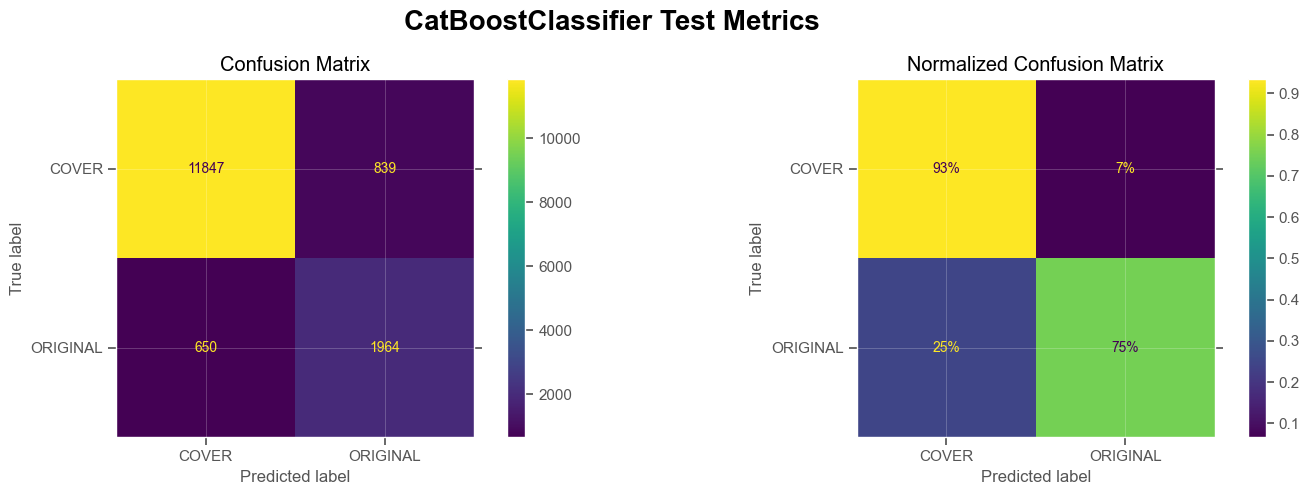


 CatBoostClassifier Classification Report: 
               precision    recall  f1-score   support

       COVER       0.95      0.93      0.94     12686
    ORIGINAL       0.70      0.75      0.73      2614

    accuracy                           0.90     15300
   macro avg       0.82      0.84      0.83     15300
weighted avg       0.91      0.90      0.90     15300



In [483]:
make_classification_plots(model.predict(data_rng), target, 'CatBoostClassifier')

# Результаты и выводы

Перед нами стояла задача разработать метод, для определения оригинальных треков для каверов. Для этого была реализована двустадийная модель, которая на первом этапе отбирала похожие по тексту треки, а на втором этапе применялась бинарная классификация по меткам COVER/ORIGINAL.

Было реализовано два подхода. Обучение задачи классификации на всех данных предоставленных сервисом. А также второй подход с ранжированием по результатам второй модели и новым признакам внутри групп каверов.

Для построения наилучшей модели кластеризации и поиска ближайших соседей исследовался стек:

        1)CountVectorizer  - Векторизация текста  
        2)TfidfVectorizer  - Векторизация текста  
        3)PCA  -Уменьшение размерности   
        4)NearestNeighbors  - Прямой поиск    
        5)Faiss  - Семантический поиск    
        6)SBERT- Векторизация текста  
        
Результаты представлены в таблице:  

<table>
    <tr>
        <td>Модель</td>
        <td>accuracy@5</td>
        <td>accuracy@25</td>
        <td>accuracy@50</td>
        <td>Время (n=5)</td>
        <td>Время (n=25)</td>
        <td>Время (n=50) </td>
    </tr>
    <tr>
        <td>CountVectorizer + NearestNeighbors</td>
        <td>46,078</td>
        <td>85,621</td>
        <td>90,85</td>
        <td>62,369</td>
        <td>61,886</td>
        <td>62,99899 </td>
    </tr>
    <tr>
        <td>CountVectorizer + PCA(1024) + NearestNeighbors</td>
        <td>41,83</td>
        <td>88,562</td>
        <td>92,81</td>
        <td>0,223</td>
        <td>0,225</td>
        <td>0,208 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + NearestNeighbors</td>
        <td>46,405</td>
        <td>91,503</td>
        <td>98,693</td>
        <td>62,05017</td>
        <td>63,7106</td>
        <td>62,01344 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(512) + NearestNeighbors</td>
        <td>46,732</td>
        <td>85,948</td>
        <td>92,484</td>
        <td>0,223</td>
        <td>0,225</td>
        <td>0,208 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(1024) + NearestNeighbors</td>
        <td>46,078</td>
        <td>85,621</td>
        <td>92,157</td>
        <td>0,44</td>
        <td>0,422</td>
        <td>0,44 </td>
    </tr>
    <tr>
        <td>TfidfVectorizer + PCA(2048) + NearestNeighbors</td>
        <td>46,078</td>
        <td>90,196</td>
        <td>97,386</td>
        <td>0,937</td>
        <td>0,942</td>
        <td>0,927 </td>
    </tr>
    <tr>
        <td> Faiss(IVFPQ)</td>
        <td>44,771</td>
        <td>82,026</td>
        <td>89,542</td>
        <td>1,86755</td>
        <td>1,533</td>
        <td>1,599 </td>
    </tr>
    <tr>
        <td>PCA(512) +  Faiss(IVFPQ)</td>
        <td>46,405</td>
        <td>84,641</td>
        <td>89,869</td>
        <td>0,005</td>
        <td>0,006</td>
        <td>0,006 </td>
    </tr>
    <tr>
        <td>PCA(1024) +  Faiss(IVFPQ)</td>
        <td>42,484</td>
        <td>86,275</td>
        <td>90,85</td>
        <td>0,008999</td>
        <td>0,009001</td>
        <td>0,008 </td>
    </tr>
    <tr>
        <td>PCA(2048) +  Faiss(IVFPQ)</td>
        <td>46,405</td>
        <td>84,967</td>
        <td>90,85</td>
        <td>0,020998</td>
        <td>0,017999</td>
        <td>0,014 </td>
    </tr>
    <tr>
        <td>Faiss(IndexIVFFlat)</td>
        <td>45,098</td>
        <td>87,908</td>
        <td>95,098</td>
        <td>9,099564</td>
        <td>9,483988</td>
        <td>9,907769 </td>
    </tr>
    <tr>
        <td>PCA(2048) + Faiss(IndexIVFFlat)</td>
        <td>46,405</td>
        <td>87,908</td>
        <td>94,771</td>
        <td>0,206999</td>
        <td>0,226941</td>
        <td>0,189997 </td>
    </tr>
    <tr>
        <td>PCA(512) + Faiss(IndexIMIFlat)</td>
        <td>46,078</td>
        <td>83,333</td>
        <td>89,216</td>
        <td>0,021999</td>
        <td>0,019998</td>
        <td>0,024 </td>
    </tr>
    <tr>
        <td>PCA(2048) + Faiss(IndexIMIFlat)</td>
        <td>46,405</td>
        <td>90,196</td>
        <td>97,386</td>
        <td>0,588001</td>
        <td>0,546999</td>
        <td>0,541 </td>
    </tr>
        <tr>
        <td>SBERT + Faiss(IndexIMIFlat)</td>
        <td>48,039</td>
        <td>93,137</td>
        <td>96,405</td>
        <td>0,011999</td>
        <td>0,008004</td>
        <td>0,007999 </td>
    </tr>
</table>

Видно, что наилучшие результаты по точности и времени работы показывают две связки:

        1)SBERT + Faiss(IndexIMIFlat) с точностью поиска = 	96,405, при n=50 и временем = 0,007999 секунды  
        2)TfidfVectorizer  + PCA(2048) + Faiss(IndexIMIFlat) = 97,386, при n=50 и временем = 0,541 секунды  

У первого варианта скорость поиска очень большая, так как SBERT выдает очень маленькую матрицу после векторизации, но он не будет работать с новыми данными, на которых он не обучался (нет метода transform). Данного недостатка нет у второго подхода. Точность у него чуть выше, но скорость поиска уступает на два порядка.  
Для применения на втором этапе первый вариант, необходимо доработать, поэтому мы тестировали финальную модель только со вторым подходом. 

Модель классификации после ранжирования показала не такой высокий результат как в п.5. Также в данном варианте была вероятность утечки информации из тренировочной выборки. Так как поиск соседей неконтролируемый процесс. Для более детальных тестов и более точных результатов, необходимо иметь больше данных с текстами, чтобы сформировать две независимые векторные базы. 